# Imports and get snapshot IDs

In [1]:
from __future__ import division

import h5py
import lightcone_routines as lcr
import match_searchsorted as mss
import numpy as np
import interpolation as interp
from collections import OrderedDict
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
#import itertools
import pandas as pd
from scipy.stats import norm
import astropy.units as u

required_snapshot_ids = None
snapshot_key_ref = None
gal_type_list = None
snapshot_ids_to_redshift = None
matched_groups = {}
ivol = [0,3,4,5,6,7]
m_trees = [62, 123, 245, 489, 977]

# gal_type = {"central": 0, "sat 1": 1, "sat 2":2}

#galaxy_data_dict = OrderedDict() #delete me

def setup(redshift = 0.3):
    global required_snapshot_ids, snapshot_key_ref, gal_type_list, snapshot_ids_to_redshift, tree_for_key
  #  global galaxy_data_dict #delete me
    # Calls routine that selects required snapshots from each merger tree at a given redshift
    required_snapshot_ids = lcr.select_snapshots(redshift = 0.3)
    max_len = max([len(snapshots) for tree, snapshots in required_snapshot_ids.items()])       
    snapshot_key_ref = {tree: np.linspace(0, max_len-1, len(snapshots), endpoint=True, dtype="int") for tree, snapshots in required_snapshot_ids.items()}
   
    
    
    ## Read In Data from Galform Files

    # Gets all required data for the selected snapshots and saves to a list within a dictionary
    galaxy_data_dict = OrderedDict()


    # Each snapshot_id becomes a key in a new dictionary, point to a list(galaxy_data_snapshot_list)
    for merger_tree in m_trees:
        #number_of_runs = len(required_snapshot_ids[merger_tree])
        galaxy_data_snapshot_list = {}
        # Each of galaxy_data_snapshot_list is populated with 8 lists(galaxy_data_ivol_list), corrosponding to ivol0 through ivol7
        # Each list is populated with data frames, containing the data
        for i, key in enumerate(snapshot_key_ref[merger_tree]):
            snapshot = required_snapshot_ids[merger_tree][i]
            galaxy_data_ivol_list = {}
            for j in ivol:
                if merger_tree != 489:
                    galaxy_data_path = "/data/dega1/iprn/galform_out/r635/mini/Gonzalez17.PAUS.MilliGas%d/ivol_%d/galaxies.hdf5" % (merger_tree, j)
                else:
                     galaxy_data_path = "/data/dega1/iprn/galform_out/r635/mini/Gonzalez17.PAUS.MilliGas489_save/ivol_%d/galaxies.hdf5" % (j)
                #print galaxy_data_path
                try:
                    galaxy_data_tmp = lcr.read_snapshot_data(snapshot = snapshot, datapath = galaxy_data_path)
                except:
                    print galaxy_data_path
                    raise
                galaxy_data_ivol_list[j] = galaxy_data_tmp
            galaxy_data_snapshot_list[key] = (galaxy_data_ivol_list)
        galaxy_data_dict[merger_tree] = galaxy_data_snapshot_list
    
#    for t in [62, 123, 245, 489, 977]:
#        for r in range(3):
#            print t, r, len(np.where(galaxy_data_dict[t][16][0]["galtype"]==r)[0])
    
    max_tree = max(m_trees)
    snapshot_ids_to_redshift = {i: galaxy_data_dict[max_tree][i][ivol[0]].iloc[0]["redshift"] for i in snapshot_key_ref[max_tree]}
    
    
    ## Mask Duplicates

    #Each snapshot_id becomes a key in a new dictionary, point to a list(galaxy_data_snapshot_list)
    for merger_tree in m_trees:

        for snapshot in snapshot_key_ref[merger_tree]:
            for j in ivol:
                #Use the ParticleID as negative as the SubHaloID
                indexes_of_type2 = np.where(galaxy_data_dict[merger_tree][snapshot][j]["galtype"] == 2)[0]
                galaxy_data_dict[merger_tree][snapshot][j].ix[indexes_of_type2,"SubhaloIndex"] = -galaxy_data_dict[merger_tree][snapshot][j].ix[indexes_of_type2,"ParticleID"]

                #Where the SubhaloID is invalid, set it to 0.
                indexes_of_problems = np.where(galaxy_data_dict[merger_tree][snapshot][j]["SubhaloID"] > 1e16 )[0]
                galaxy_data_dict[merger_tree][snapshot][j].ix[indexes_of_problems,"SubhaloIndex"] = 0




    
    
    ## Split Between Galaxy Types

    #Creates a new dictionary containing data for central galaxies only
    centrals = OrderedDict()
    satell1s = OrderedDict()
    satell2s = OrderedDict()
    for merger_tree in galaxy_data_dict:
       # snapshot = len(required_snapshot_ids[merger_tree])

        central_data_snapshot_list = {}
        satell1_data_snapshot_list = {}
        satell2_data_snapshot_list = {}
        #data_snapshot_list = {}
        for i in snapshot_key_ref[merger_tree]:
            central_data_ivol_list = {}
            satell1_data_ivol_list = {}
            satell2_data_ivol_list = {}
            #data_ivol_list = []
            for j in ivol:
                current_data = galaxy_data_dict[merger_tree][i][j]
                #print np.logical_and(current_data['galtype'] == 0, current_data['SubhaloIndex']!=0)
                central_data_ivol_list[j] = current_data.loc[np.logical_and(current_data['galtype'] == 0, current_data['SubhaloIndex']!=0)]
                satell1_data_ivol_list[j] = current_data.loc[np.logical_and(current_data['galtype'] == 1, current_data['SubhaloIndex']!=0)]
                satell2_data_ivol_list[j] = current_data.loc[np.logical_and(current_data['galtype'] == 2, current_data['SubhaloIndex']!=0)]



            central_data_snapshot_list[i] = central_data_ivol_list
            satell1_data_snapshot_list[i] = satell1_data_ivol_list
            satell2_data_snapshot_list[i] = satell2_data_ivol_list
        centrals[merger_tree] = central_data_snapshot_list
        satell1s[merger_tree] = satell1_data_snapshot_list
        satell2s[merger_tree] = satell2_data_snapshot_list

    gal_type_list = {0: centrals, 1: satell1s, 2: satell2s}
    #tree_for_key = min(required_snapshot_ids.keys())
#    for i in [0, 1]:
#        for tree in [62, 123, 245, 489, 977]:
#                for ss in snapshot_key_ref[tree]:
#                    print np.any(gal_type_list[0][62][0][0]["DescendantID"] == gal_type_list[0][62][0][0]["GalaxyID"]


#if __name__=="__main__":
#    setup()
    

# Creates Galaxy/Descendant Groups

In [2]:
def get_descendants(tree = 62, sub_volumes=0, gal_type=0):
    '''
    For a given tree, and given sub_volumes, get a list of groups of descendants. (Returned as a dictionary of dictionaries,
    with the SubhaloIndex of the galaxy in snapshot 0 as the keys of the outer dictionary, and the snapshot as the key to the
    inner ones).
    '''
    #Checks if DescendantID and GalaxyID match, gets the index number of Galaxy/Descendant pairs and saves to dict
    matching_groups = {}
    #Get data from each ivol in turn
    for subvol in np.atleast_1d(sub_volumes):
        snapshots = {}
        matches = {}
        matching_row_indexes = {}
        list_of_snapshots = list(snapshot_key_ref[tree])
        
        # Get the data from gal_type_list in a convienient place
        for num in list_of_snapshots:
            #print num
            snapshots[num] = gal_type_list[gal_type][tree][num][subvol]
            
        # For each snapshot (bar the first) - find the indicies in the previous snapshot where the previous
        # GalaxyID matches the current DescendantID
        matching_row_indexes[0] = np.arange(len(snapshots[0]))
        for i, num in enumerate(list_of_snapshots[1:], 1):
            arr1 = np.asarray(snapshots[num]["DescendantID"])
            arr2 = np.asarray(snapshots[list_of_snapshots[i-1]]["GalaxyID"])
            matching_row_indexes[num] = mss.match(arr1, arr2, print_arrays=False)
        
        # Have to work through the snapshots in reverse order now
        revs = list_of_snapshots # okay, I know this is unnessessary, but it was easier for me to read
        revs.reverse()
        
        dead_end_counter = 0 #can be deleted
        
        # Loop through each galaxy:
        # Starting with the last snapshot, add it to the group.  Then find the index of it in the previous time and add
        # that to the loop.  etc
        for index in range(len(matching_row_indexes[revs[0]])):
            group = {}
            group[revs[0]] = snapshots[revs[0]].iloc[[index]]

            for i, num in enumerate(revs[1:],1):
                index = matching_row_indexes[revs[i-1]][index]
                if index == -1:
                    # This trail is a dead end.
                    dead_end_counter +=1
                    break
                group[num] = snapshots[num].iloc[[index]]
            # If you didn't hit a dead end, Put the group in snapshot order
            else:
                #group.reverse()

                # Deal with wrap-around:
                # boxsize = 125
                for coord in ["xgal", "ygal", "zgal"]:
                    values = [gal[coord].iloc[0] for gal in group.values()]
                    if max(values) > 120 and min(values) < 5:
                        for gal in group.values():
                            if gal[coord].iloc[0] > 80:
                                gal[coord].iat[0] -= 125
              
                matching_groups[group[0]["SubhaloIndex"].iloc[0]] = group
        #print dead_end_counter
    return matching_groups        

# Get data of matching sets of galaxies

In [3]:
def get_matches(merger_tree_list=[62,123,245], snapshot=0, sub_volumes=0, gal_type=0):
    '''
    NOT CALLED ANYMORE, BUT COULD BE USEFUL?
    
    Calls John's function to pair the indices of the matching SubhaloIndex values across merger trees. 
    Returns a dictionary of dictionary of (tree: galaxy) for each of the three merger trees, for each galaxy, 
    with the SubHaloIndex as the key.
    
    Works best when merger_tree_list is given in order, such as [62, 123, 245]
    '''
    if len(np.atleast_1d(merger_tree_list)) < 2:
        # Probably best replaced with raising an exception
        return "Need at least 2 lists to compare.  This won't do:", merger_tree_list
    
    gal_data = {}
    
    # Do each ivol in turn
    for subvol in np.atleast_1d(sub_volumes):
        
        SubhaloIndicies = OrderedDict()
        
        # For each merger tree, get the galaxys that haven't been flagged to have a duplicated SubhaloID
        for tree in merger_tree_list:
            try:
                all_gal = gal_type_list[gal_type][tree][snapshot][subvol] 
                non_zeros = np.where(all_gal["SubhaloIndex"] != 0)[0]
                SubhaloIndicies[tree] = all_gal.iloc[non_zeros]
            except:
                print len(gal_type_list[gal_type] )
                raise
        
        # Seperate the bottom tree
        list_of_trees = list(merger_tree_list)
        bottom_tree = list_of_trees.pop()
        
        
        
        # For each tree:
        # - Go through the botton_tree, and see if a matching SubhaloIndex can be found in the other trees.
        # - If so, at the same index as in bottom_tree, store the index of the galaxy in the other tree.
        # - If not, store -1
        matches = []
        for tree in list_of_trees:
            matches.append(mss.match(SubhaloIndicies[bottom_tree]["SubhaloIndex"].values, 
                                     SubhaloIndicies[tree]["SubhaloIndex"].values, print_arrays=False))

        matches = np.asarray(matches)
        # Get incicies of the arrays that corrospond to a galaxy in all trees
        indicies_index = np.where(np.apply_along_axis(np.all, 0, matches!=-1))[0]
        
        # For each index in the above array, which corrosponds to indices in the trees where the same galaxy can be found:        
        for i in indicies_index:
            # Get a list of the indicies in each tree in turn: [<index in tree 0>, <index in tree 1>, ...]
            group = []
            group.extend(matches[:,i])
            group.append(i)
           
            if -1 in group:
                # This shouldn't be possible to occur. But if it does, bad news.
                # Probably best replaced with raising an exception
                return str(i) + " uh oh ", group
            
            # Turn this list into galaxy data, and then add to list to be returned.    
            matched_gals = {}
            for j, index in enumerate(list_of_trees):
                matched_gals[index] = SubhaloIndicies[index].iloc[group[j]] 
            
            matched_gals[bottom_tree] =  SubhaloIndicies[bottom_tree].iloc[group[-1]]
            gal_data[matched_gals[bottom_tree]["SubhaloIndex"]] = matched_gals
            
               
    return gal_data

In [4]:
def get_descendants_of_matches(match_key, match, all_descendants, trees=[62,123,245]):
    '''
    Returns pairs of match_key, and a dicitionary of the desendents in each tree.
    '''
    desend = {}
    # Loop through each tree
    for i, tree in enumerate(trees):
        try:
            # Asign the desendent group to the dictionary, with tree as the key
            desend[tree] = all_descendants[tree][match[i]["SubhaloIndex"]]
        except:
            print i, tree
            raise
    # Check all trees were found.
    if Counter(desend.keys()) == Counter(trees):
        return match_key, desend

In [5]:
def get_all_matching_descendants_groups(merger_tree_list=[62,123,245], sub_volumes=0, gal_type=0):
    '''
    At the moment, doesn't work with type 2 - appears to be some duplicates!
    
    Returns a dictionary, of dictionaries, of dictionaries.  The main dictionary key is the SubhaloIndex of the galaxy in the 
        first snapshot.  Each dictionary inside this has keys that are merger trees.  The innermost dicitonaries have keys of
        the snapshot, and a value of the galaxy at that snapshot.

    '''
    
    # Get descendant groups for each tree
    d = {tree: get_descendants(tree, sub_volumes=sub_volumes, gal_type=gal_type) for tree in merger_tree_list}
    groups = {}
    
    
    # Loop through each grouping in the first tree (usually - 62.  It should be the lowest!)
    for key in d[merger_tree_list[0]].keys():
        desend = {}
        # Each tree uses the *same* key to represent a group of galaxies.
        # See if that key is in all the trees avaliable
        if np.all([(key in d[tree].keys()) for tree in merger_tree_list]): #(key in d[123].keys() and key in d[245].keys())
            # if the galaxy is found in all the trees, add these to the dictionary for this galaxy
            for tree in merger_tree_list:
                desend[tree] = d[tree][key]
            if key in groups:
                # If we end up here - there is a repeated galaxy key.  Happens for type 2 satellites
                print "uh oh", key
                return groups
            # Add the dictionary of galaxies to the final galaxy to be returned.
            groups[key] = desend
    
    return groups   


# Match Up Central/Satellite Galaxies

In [6]:
def get_complete_data(merger_tree_list=[62,123,245], sub_volumes=0):
    '''
    NOT CALLED ANYMORE, BUT COULD BE USEFUL?
    
    Returns:     (Matches, Desendents)
    Matches:     A dictionary of dictionarys, in the outer dictionary, the keys are the SubhaloIndex.
        The inner dictionary has pairs of (tree: galaxy in that tree))

    Desendents:  Dictionary with tree as key.  Item is a dictionary of dictionarys, of these the outer dictionary has
        key of the SubhaloIndex of the youngest galaxy.  The inner dicitionary has pairs (snapshot: galaxy at that snapshot)
    
    At the moment, only works with central galaxies
    '''
    
    # simply gets the matches, and descendents together.
    matches = get_matches(merger_tree_list, sub_volumes=sub_volumes)     
    descendants = {tree: get_descendants(tree, sub_volumes=sub_volumes) for tree in merger_tree_list}
    
    return matches, descendants

In [7]:
def get_sat_cen(tree, snapshot=0, sub_volumes=0, sat_type = 1):
    '''
    Gives list of tuples: (central galaxy: list of Satellite Galaxies)
    For each central galaxy that has satellites.
    '''
    sat_cen = []
    for subvol in np.atleast_1d(sub_volumes):
        # List of all relevent central galaxies
        arr1 = gal_type_list[0][tree][snapshot][subvol]
        # List of all relevent satellite galaxies
        arr2 = gal_type_list[sat_type][tree][snapshot][subvol]
        
        key = "DHaloID"
        
        # Loop through central galaxies
        for i, cen_gal in enumerate(arr1.itertuples()):
            # if it has any satellites of the correct type
            if np.any(arr2[key].values == cen_gal.DHaloID):
                # then add the tuple to the list.
                # tuple has a DataFrame which contains all the satellites of the central galaxy
                sat_cen.append( (arr1.iloc[[i]],  [arr2.iloc[[j]] for j in np.where(arr2[key].values == cen_gal.DHaloID)[0]]) )
   
    return sat_cen

In [8]:
def get_sat_cen_matches((cen, sats), gal_type=1):
    '''
    Takes in a tuple - (central galaxy: list of Satellite Galaxies)
    Data MUST have come from shortest tree, youngest snapshot.
    Only works for gal_type=1 satellites
    '''
    
    if (cen["SubhaloIndex"].iloc[0] not in matched_groups[0].keys()):
        # Center galaxy cannot be found
        return "fail1"
    
    # Gets the group related the central galaxy
    cen_group = matched_groups[0][cen["SubhaloIndex"].iloc[0]]
    
    # Gets all the satellite groups it can find from the "sats" list
    sats_groups = [matched_groups[gal_type][sat["SubhaloIndex"].iloc[0]] for sat in sats if sat["SubhaloIndex"].iloc[0] in matched_groups[gal_type]]
    
    if len(sats_groups) == 0:
        # No satellite galaxies can be found
        return "fail2"

    
    return (cen_group, sats_groups)

In [9]:
# There is probably a way to combine these into one function, but there's no real need.
def get_central_interp(item, tree, redshifts_to_interp = None):
    '''
    Does some interpolation - primary use is plots
    
    Item needs to be a dictionary of matched desendents.
    tree is the tree for which interpolation is done
    redshifts_to_interp is the redshifts at which to interpolate.  If None, it does a time-spaced interpolation
    '''

    # Use the data from the correct tree
    item = item[tree]
        
    vel = np.zeros((0,3))
    pos = np.zeros((0,3))
    times = np.zeros((0))
    
    # Loop through the snapshots between which you are interpolation.
    # Get data from the next one for the interpolation
    for i, ss in enumerate(snapshot_key_ref[tree][:-1]):
        z_red_i1 = item[snapshot_key_ref[tree][i+1]]["redshift"].iloc[0]
        z_red_f1 = item[ss]["redshift"].iloc[0]
        xi1, yi1, zi1    = item[snapshot_key_ref[tree][i+1]][["xgal","ygal","zgal"]].iloc[0]
        vxi1, vyi1, vzi1 = item[snapshot_key_ref[tree][i+1]][["vxgal","vygal","vzgal"]].iloc[0]
        xf1, yf1, zf1    = item[ss][["xgal","ygal","zgal"]].iloc[0]
        vxf1, vyf1, vzf1 = item[ss][["vxgal","vygal","vzgal"]].iloc[0]

        if redshifts_to_interp:
            # Get the redshifts for the interpolation
            rs_to_interp = [rs for rs in redshifts_to_interp if (rs <= z_red_i1 and rs >= z_red_f1)]
            rs_to_interp.reverse()
             
            # If there are any redshifts to interpolate at between the two points
            if rs_to_interp:
                times1, pos1, vel1 = interp.interpolate_cen_cen(xi1, yi1, zi1, vxi1, vyi1, vzi1,
                                                                xf1, yf1, zf1, vxf1, vyf1, vzf1,
                                                                z_red_i1, z_red_f1, rs_to_interp)
               
        else:
            # Not specified to interpolated at certian redshifts, so get a time spaced interpolation
            times1, pos1, vel1 = interp.time_spaced_interpolation_cen_cen(xi1, yi1, zi1, vxi1, vyi1, vzi1,
                                                                          xf1, yf1, zf1, vxf1, vyf1, vzf1,
                                                                          z_red_i1, z_red_f1)
            
        # Get them all into one array  
        times, pos, vel = np.concatenate((times1, times)), np.concatenate((pos1, pos)), np.concatenate((vel1, vel))
    return times, pos, vel


def pos_av_interp(item, tree, redshifts_to_interp = None):
    '''
    Cubic interpolation for centrals, exactly like get_central_interp.
    But uses the average velocity { (xf-xi)/(tf-ti) } as both the start and end points
    '''
    item = item[tree]

    vel = np.zeros((0,3))
    pos = np.zeros((0,3))
    times = np.zeros((0))
    for i, ss in enumerate(snapshot_key_ref[tree][:-1]):
        z_red_i1 = item[snapshot_key_ref[tree][i+1]]["redshift"].iloc[0]
        z_red_f1 = item[ss]["redshift"].iloc[0]
        xi1, yi1, zi1    = item[snapshot_key_ref[tree][i+1]][["xgal","ygal","zgal"]].iloc[0]
        xf1, yf1, zf1    = item[ss][["xgal","ygal","zgal"]].iloc[0]
        dist = (np.array([xf1, yf1, zf1]) - np.array([xi1, yi1, zi1]))/interp.cosmo.h
        time = (interp.cosmo.age(z_red_f1) - interp.cosmo.age(z_red_i1))
        to_speed = (dist / time.value) * (1 *u.Mpc / u.Gyr).to( u.km / u.s).value
        vxi1, vyi1, vzi1 = to_speed
        vxf1, vyf1, vzf1 = vxi1, vyi1, vzi1


        if redshifts_to_interp:
            rs_to_interp = [rs for rs in redshifts_to_interp if (rs <= z_red_i1 and rs >= z_red_f1)]
            rs_to_interp.reverse()
         #   print rs_to_interp
            if rs_to_interp:
                times1, pos1, vel1 = interp.interpolate_cen_cen(xi1, yi1, zi1, vxi1, vyi1, vzi1,
                                                                xf1, yf1, zf1, vxf1, vyf1, vzf1,
                                                                z_red_i1, z_red_f1, rs_to_interp)

        else:
            times1, pos1, vel1 = interp.time_spaced_interpolation_cen_cen(xi1, yi1, zi1, vxi1, vyi1, vzi1,
                                                                          xf1, yf1, zf1, vxf1, vyf1, vzf1,
                                                                          z_red_i1, z_red_f1)

        #print times1  
        times, pos, vel = np.concatenate((times1, times)), np.concatenate((pos1, pos)), np.concatenate((vel1, vel))
    return times, pos, vel


def vel_av_interp(item, tree, redshifts_to_interp = None):
    '''
    Cubic interpolation for centrals, exactly like get_central_interp.
    But uses the average velocity { (vf+vi)/2 } as both the start and end points
    '''
    item = item[tree]

    vel = np.zeros((0,3))
    pos = np.zeros((0,3))
    times = np.zeros((0))
    for i, ss in enumerate(snapshot_key_ref[tree][:-1]):
        z_red_i1 = item[snapshot_key_ref[tree][i+1]]["redshift"].iloc[0]
        z_red_f1 = item[ss]["redshift"].iloc[0]
        xi1, yi1, zi1    = item[snapshot_key_ref[tree][i+1]][["xgal","ygal","zgal"]].iloc[0]
        vxi1, vyi1, vzi1 = (np.array(item[snapshot_key_ref[tree][i+1]][["vxgal","vygal","vzgal"]].iloc[0]) + np.array(item[ss][["vxgal","vygal","vzgal"]].iloc[0])) / 2
        xf1, yf1, zf1    = item[ss][["xgal","ygal","zgal"]].iloc[0]
        vxf1, vyf1, vzf1 = vxi1, vyi1, vzi1

        if redshifts_to_interp:
            rs_to_interp = [rs for rs in redshifts_to_interp if (rs <= z_red_i1 and rs >= z_red_f1)]
            rs_to_interp.reverse()
         #   print rs_to_interp
            if rs_to_interp:
                times1, pos1, vel1 = interp.interpolate_cen_cen(xi1, yi1, zi1, vxi1, vyi1, vzi1,
                                                                xf1, yf1, zf1, vxf1, vyf1, vzf1,
                                                                z_red_i1, z_red_f1, rs_to_interp)

        else:
            times1, pos1, vel1 = interp.time_spaced_interpolation_cen_cen(xi1, yi1, zi1, vxi1, vyi1, vzi1,
                                                                          xf1, yf1, zf1, vxf1, vyf1, vzf1,
                                                                          z_red_i1, z_red_f1)

        #print times1  
        times, pos, vel = np.concatenate((times1, times)), np.concatenate((pos1, pos)), np.concatenate((vel1, vel))
    return times, pos, vel

In [10]:
def find_cen_deviation(item, tree_for_interpolation, snapshots_for_statistics = range(16), interp_to_use = None):
    '''
    Finds deviations for the central galaxy.
    interp_to_use can be any central interpolation function.  It defaults to "get_central_interp" if not set.
    Ensure that all snapshots given correspond to snapshots avaliable for the galaxy
    '''
    
    if not interp_to_use:
        interp_to_use = get_central_interp
    
    # A list of the snapshots at which to find the deviation
    snaps_without_interp = [i for i in snapshots_for_statistics if i not in snapshot_key_ref[tree_for_interpolation]]

    # Where to interpolate at
    redshifts_for_statistics = [snapshot_ids_to_redshift[s] for s in snaps_without_interp]

    
    # Do the interpolation!
    times, pos, vel = interp_to_use(item, tree_for_interpolation, redshifts_for_statistics)
       
    if len(pos) != len(snaps_without_interp):
        print "Ensure snapshots for statistics are within those used for interpolation"
        return None
    
    # Get the data of the galaxy
    data_pos = [np.asarray(item[max(snapshot_key_ref)][x][["xgal", "ygal", "zgal"]].iloc[0]).tolist() for x in snaps_without_interp]
    data_vel = [np.asarray(item[max(snapshot_key_ref)][x][["vxgal", "vygal", "vzgal"]].iloc[0]).tolist() for x in snaps_without_interp]
    
    data_pos.reverse()
    data_vel.reverse()

    # Get the deviations
    deviation =  np.linalg.norm(pos - data_pos, axis=1)
    vel_deviation =  np.linalg.norm(vel - data_vel, axis=1)
    
    return deviation, vel_deviation
    

In [11]:
def get_satellite_interp((cen, sat), tree, redshifts_to_interp = None):
    '''
    Does some interpolation - primary use is plots
    
    cen, sat needs to be dictionaries of matched desendents.
    tree is the tree for which interpolation is done
    redshifts_to_interp is the redshifts at which to interpolate.  If None, it does a time-spaced interpolation
    '''

    # Not commented yet.  See comments in find_cen_deviation for guidence - it's the same algorithm
    
    
    cen, sat = cen[tree], sat[tree]
    
    cen_vel, sat_vel = np.zeros((0,3)), np.zeros((0,3))
    cen_pos, sat_pos = np.zeros((0,3)), np.zeros((0,3))
    times = np.zeros((0))
    
    for i, ss in enumerate(snapshot_key_ref[tree][:-1]):
        z_red_i = sat[snapshot_key_ref[tree][i+1]]["redshift"].iloc[0]
        z_red_f = sat[ss]["redshift"].iloc[0]
        
        cen_xi, cen_yi, cen_zi    = cen[snapshot_key_ref[tree][i+1]].iloc[0]["xgal":"zgal"]
        cen_vxi, cen_vyi, cen_vzi = cen[snapshot_key_ref[tree][i+1]].iloc[0]["vxgal":"vzgal"]
        cen_xf, cen_yf, cen_zf    = cen[ss].iloc[0]["xgal":"zgal"]
        cen_vxf, cen_vyf, cen_vzf = cen[ss].iloc[0]["vxgal":"vzgal"]
        
        sat_xi, sat_yi, sat_zi    = sat[snapshot_key_ref[tree][i+1]].iloc[0]["xgal":"zgal"]
        sat_vxi, sat_vyi, sat_vzi = sat[snapshot_key_ref[tree][i+1]].iloc[0]["vxgal":"vzgal"]
        sat_xf, sat_yf, sat_zf    = sat[ss].iloc[0]["xgal":"zgal"]
        sat_vxf, sat_vyf, sat_vzf = sat[ss].iloc[0]["vxgal":"vzgal"]

        if redshifts_to_interp:
            rs_to_interp = [rs for rs in redshifts_to_interp if (rs <= z_red_i and rs >= z_red_f)]
            rs_to_interp.reverse()
            if rs_to_interp:
                times1, (cen_pos1, cen_vel1), (sat_pos1, sat_vel1) = interp.interpolate_sat_sat(sat_xi, sat_yi, sat_zi, 
                                                                                                sat_vxi, sat_vyi, sat_vzi,
                                                                                                sat_xf, sat_yf, sat_zf, 
                                                                                                sat_vxf, sat_vyf, sat_vzf,
                                                                                                cen_xi, cen_yi, cen_zi, 
                                                                                                cen_vxi, cen_vyi, cen_vzi,
                                                                                                cen_xf, cen_yf, cen_zf, 
                                                                                                cen_vxf, cen_vyf, cen_vzf, 
                                                                                                z_red_i, z_red_f, 
                                                                                                rs_to_interp)
                
                           
               
        else:
            times1, (cen_pos1, cen_vel1), (sat_pos1, sat_vel1) = interp.time_spaced_interpolation_sat_sat(sat_xi, sat_yi, sat_zi,
                                                                                                          sat_vxi, sat_vyi, sat_vzi,
                                                                                                          sat_xf, sat_yf, sat_zf,
                                                                                                          sat_vxf, sat_vyf, sat_vzf,
                                                                                                          cen_xi, cen_yi, cen_zi,
                                                                                                          cen_vxi, cen_vyi, cen_vzi,
                                                                                                          cen_xf, cen_yf, cen_zf,
                                                                                                          cen_vxf, cen_vyf, cen_vzf,
                                                                                                          z_red_i, z_red_f)
        times = np.concatenate((times1, times))
        cen_pos, cen_vel =  np.concatenate((cen_pos1, cen_pos)), np.concatenate((cen_vel1, cen_vel))
        sat_pos, sat_vel =  np.concatenate((sat_pos1, sat_pos)), np.concatenate((sat_vel1, sat_vel))
        
    return times, (cen_pos, cen_vel), (sat_pos, sat_vel)

In [12]:
def find_sat_deviation((cen, sat), tree_for_interpolation, snapshots_for_statistics = range(16)):#(galaxy_descendants, snapshots_for_statistics=[0,1,2,3,4], snapshots_for_interpolation = [0,4]):
    '''
    Ensure that all snapshots given correspond to snapshots avaliable for the galaxy
    
    WANRING:  NOT TESTED, AND PROBABLY (ALMOST CERTIANLY) OUTDATED AND WON'T WORK!!!
    '''
    
    stats_without_interp = [i for i in snapshots_for_statistics if i not in snapshot_key_ref[tree_for_interpolation]]
    
    #print galaxy_descendants

    redshifts_for_statistics = [snapshot_ids_to_redshift[s] for s in stats_without_interp]
    
    times, (cen_pos, cen_vel), (sat_pos, sat_vel) = get_satellite_interp((cen, sat), tree_for_interpolation, redshifts_for_statistics)
    
    if len(pos) != len(stats_without_interp):
        print "Ensure snapshots for statistics are within those used for interpolation"
        return None

    deviation =  np.linalg.norm(sat_pos - [np.asarray(sat[max(snapshot_key_ref)][x][["xgal", "ygal", "zgal"]].iloc[0]) for x in stats_without_interp], axis=1)
    #print pos
    #print galaxy_descendants.iloc[stats_without_interp][["xgal", "ygal", "zgal"]]
    return deviation
    

In [13]:
def __make_central_plot(item, tree_for_interp = 489, trees_to_plot = [62,123,245,489,977]):
    '''
    Produces a plot of the position of a cenral galaxy, plus it's interpolation.
    Uses infomation from all tress - up to 977
    '''
    
    # So that the graphs are plotted with the correct tree on top
    trees_to_plot.sort()
    trees_to_plot.reverse()
    
    # Highest Redshift
    oldest_snapshot = max([snapshot_ids_to_redshift[tr] for tr in trees_to_plot])
    # Shortest tree
    shortest_tree = min(trees_to_plot)
    # Longest tree
    longest_tree = max(trees_to_plot)
    
    t, pos, v = get_central_interp(item, tree_for_interp)
    crosses = get_central_interp(item, tree_for_interp, snapshot_ids_to_redshift.values())[1]

    # Set distances to subtract - scales eveything down to around the origin    
    xstart = item[shortest_tree][oldest_snapshot]["xgal"].iloc[0] 
    ystart = item[shortest_tree][oldest_snapshot]["ygal"].iloc[0] 
    zstart = item[shortest_tree][oldest_snapshot]["zgal"].iloc[0] 
    x_points, y_points, z_points = zip(*[v[["xgal","ygal","zgal"]].iloc[0] for v in item[longest_tree].values()])
    
    x_points -= xstart
    y_points -= ystart
    z_points -= zstart
    
    # Plot the figure
    plt.figure(figsize=(15,12))
    plt.subplot(221)
    plt.title("X-Y Plane")
    plt.scatter(crosses[:,0]-xstart, crosses[:,1]-ystart, s=100, marker="x", c="black", label="Pos at snapshots")    
    plt.scatter(item[62][16]["xgal"].iloc[0]-xstart, item[62][16]["ygal"].iloc[0]-ystart, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(pos[:,0]-xstart, pos[:,1]-ystart, c="black", label="Interp from " + str(tree_for_interp))
    for tree in trees_to_plot:
        plt.scatter([v["xgal"].iloc[0]-xstart for v in item[tree].values()], [v["ygal"].iloc[0]-ystart for v in item[tree].values()], marker="*", label=tree)
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[489].values()], [v["ygal"].iloc[0]-ystart for v in item[489].values()], marker="^", label="489")
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[245].values()], [v["ygal"].iloc[0]-ystart for v in item[245].values()], marker="o", label="245")
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[123].values()], [v["ygal"].iloc[0]-ystart for v in item[123].values()], marker="x", label="123")
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[62].values()], [v["ygal"].iloc[0]-ystart for v in item[62].values()], marker="+", label="62")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")

    plt.subplot(222)
    plt.title("Y-Z Plane")
    plt.scatter(crosses[:,2]-zstart, crosses[:,1]-ystart, s=100, marker="x", c="black", label="Pos at snapshots")    
    plt.scatter(item[62][16]["ygal"].iloc[0]-ystart, item[62][16]["zgal"].iloc[0]-zstart, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(pos[:,2]-zstart, pos[:,1]-ystart, c="black", label="Interp from " + str(tree_for_interp))
    for tree in trees_to_plot:
        plt.scatter([v["zgal"].iloc[0]-zstart for v in item[tree].values()], [v["ygal"].iloc[0]-ystart for v in item[tree].values()], marker="*", label=tree)
    #plt.scatter([v["zgal"].iloc[0]-zstart for v in item[489].values()], [v["ygal"].iloc[0]-ystart for v in item[489].values()], marker="^", label="489")
    #plt.scatter([v["zgal"].iloc[0]-zstart for v in item[245].values()], [v["ygal"].iloc[0]-ystart for v in item[245].values()], marker="o", label="245")
    #plt.scatter([v["zgal"].iloc[0]-zstart for v in item[123].values()], [v["ygal"].iloc[0]-ystart for v in item[123].values()], marker="x", label="123")
    #plt.scatter([v["zgal"].iloc[0]-zstart for v in item[62].values()], [v["ygal"].iloc[0]-ystart for v in item[62].values()], marker="+", label="62")
    plt.xlabel("z gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")


    plt.subplot(223)
    plt.title("X-Z Plane")    
    plt.scatter(crosses[:,0]-xstart, crosses[:,2]-zstart, s=100, marker="x", c="black", label="Pos at snapshots")    
    plt.scatter(item[62][16]["xgal"].iloc[0]-xstart, item[62][16]["zgal"].iloc[0]-zstart, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(pos[:,0]-xstart, pos[:,2]-zstart, c="black", label="Interp from " + str(tree_for_interp))
    for tree in trees_to_plot:
        plt.scatter([v["xgal"].iloc[0]-xstart for v in item[tree].values()], [v["zgal"].iloc[0]-zstart for v in item[tree].values()], marker="*", label=tree)
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[489].values()], [v["zgal"].iloc[0]-zstart for v in item[489].values()], marker="^", label="489")
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[245].values()], [v["zgal"].iloc[0]-zstart for v in item[245].values()], marker="o", label="245")
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[123].values()], [v["zgal"].iloc[0]-zstart for v in item[123].values()], marker="x", label="123")
    #plt.scatter([v["xgal"].iloc[0]-xstart for v in item[62].values()], [v["zgal"].iloc[0]-zstart for v in item[62].values()], marker="+", label="62")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("z gal / $Mpc.h^{-1}$")


    plt.legend()
    plt.show()

In [14]:
def test_cen_interp(item, tree_for_interp = 489, title=None):
    '''
    Produces a plot of the position of a cenral galaxy, plus it's interpolation.
    Uses infomation from all tress - up to 977
    '''   

    t_d, pos_d, v_d = get_central_interp(item, tree_for_interp)
    crosses_d = get_central_interp(item, tree_for_interp, snapshot_ids_to_redshift.values())[1]
    
    t_p, pos_p, v_p = pos_av_interp(item, tree_for_interp)
    crosses_p = pos_av_interp(item, tree_for_interp, snapshot_ids_to_redshift.values())[1]
    
    t_v, pos_v, v_v = vel_av_interp(item, tree_for_interp)
    crosses_v = vel_av_interp(item, tree_for_interp, snapshot_ids_to_redshift.values())[1]
   
    #ls = oldest_snapshot
    
    xstart = item[62][16]["xgal"].iloc[0] 
    ystart = item[62][16]["ygal"].iloc[0] 
    zstart = item[62][16]["zgal"].iloc[0] 
    x_points, y_points, z_points = zip(*[v[["xgal","ygal","zgal"]].iloc[0] for v in item[977].values()])
    
    x_points -= xstart
    y_points -= ystart
    z_points -= zstart
    
    fig = plt.figure(figsize=(15,20))
  
    plt.subplot(321)
    plt.title("X-Y Plane")
    plt.scatter(crosses_d[:,0]-xstart, crosses_d[:,1]-ystart, s=100, marker="x", c="black", label="Pos at snapshots")
    plt.scatter(crosses_p[:,0]-xstart, crosses_p[:,1]-ystart, s=100, marker="x", c="red", label="Pos at snapshots")
    plt.scatter(crosses_v[:,0]-xstart, crosses_v[:,1]-ystart, s=100, marker="x", c="blue", label="Pos at snapshots")
    plt.scatter(0, 0, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(pos_d[:,0]-xstart, pos_d[:,1]-ystart, c="black", label="Interp from original")
    plt.plot(pos_p[:,0]-xstart, pos_p[:,1]-ystart, c="red", label="Interp from pos_average")
    plt.plot(pos_v[:,0]-xstart, pos_v[:,1]-ystart, c="blue", label="Interp from vel_average")
    plt.scatter([v["xgal"].iloc[0]-xstart for v in item[977].values()], [v["ygal"].iloc[0]-ystart for v in item[977].values()], marker="*", label="977")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")
    
    plt.legend()
    
    plt.subplot(322)
    plt.title("X-Y Plane")
    plt.scatter(crosses_d[:,0]-xstart, crosses_d[:,1]-ystart, s=100, marker="x", c="black", label="Pos at snapshots")
    plt.scatter(0, 0, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(pos_d[:,0]-xstart, pos_d[:,1]-ystart, c="black", label="Interp from origional")
    plt.scatter([v["xgal"].iloc[0]-xstart for v in item[977].values()], [v["ygal"].iloc[0]-ystart for v in item[977].values()], marker="*", label="977")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")
    
    
   
    plt.subplot(323)
    
    plt.title("X-Y Plane")
    plt.scatter(crosses_p[:,0]-xstart, crosses_p[:,1]-ystart, s=100, marker="x", c="red", label="Pos at snapshots") 
    plt.scatter(0, 0, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(pos_p[:,0]-xstart, pos_p[:,1]-ystart, c="red", label="Interp from pos_average")
    plt.scatter([v["xgal"].iloc[0]-xstart for v in item[977].values()], [v["ygal"].iloc[0]-ystart for v in item[977].values()], marker="*", label="977")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")
    

    plt.subplot(324)
    plt.title("X-Y Plane")
    plt.scatter(crosses_v[:,0]-xstart, crosses_v[:,1]-ystart, s=100, marker="x", c="blue", label="Pos at snapshots")
    plt.scatter(0, 0, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(pos_v[:,0]-xstart, pos_v[:,1]-ystart, c="blue", label="Interp from vel_average")
    plt.scatter([v["xgal"].iloc[0]-xstart for v in item[977].values()], [v["ygal"].iloc[0]-ystart for v in item[977].values()], marker="*", label="977")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")


    plt.subplot(325)

    plt.title("Difference between original cubic and velocity average cubic")
    diffs = np.linalg.norm(pos_v - pos_d, axis=1)
    plt.plot(np.arange(len(diffs))/(len(diffs)-1), diffs*1000)
    plt.ylabel("Difference / $kpc.h^{-1}$")
    plt.xlabel("How far along trajectory")
    
    fig.tight_layout()
    
    if title:
        plt.suptitle(title, size=16)
        fig.subplots_adjust(top=0.93)
    plt.show()

In [15]:
def __make_central_plot_vel_space(item, tree_for_interp = 489, oldest_snapshot = 16):
    '''
    Produces a plot of the velocity of a cenral galaxy, plus it's interpolation.
    Uses infomation from all tress - up to 977
    '''
  #  print [v["xgal"] for v in item[977].values()]

    t, pos, vels = get_central_interp(item, tree_for_interp)
    crosses = get_central_interp(item, tree_for_interp, snapshot_ids_to_redshift.values())[2]
    #print pos
   # print t
   # ls = oldest_snapshot
  
    xstart = item[62][16]["vxgal"].iloc[0] *0
    ystart = item[62][16]["vygal"].iloc[0] *0
    zstart = item[62][16]["vzgal"].iloc[0] *0
    x_points, y_points, z_points = zip(*[v[["vxgal","vygal","vzgal"]].iloc[0] for v in item[977].values()])
    
    x_points -= xstart
    y_points -= ystart
    z_points -= zstart
    
    plt.figure(figsize=(15,12))
    plt.subplot(221)
    plt.title("X-Y Plane")
    plt.scatter(crosses[:,0]-xstart, crosses[:,1]-ystart, s=100, marker="x", c="black", label="Pos at snapshots")    
    plt.scatter(item[62][16]["vxgal"].iloc[0]-xstart, item[62][16]["vygal"].iloc[0]-ystart, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(vels[:,0]-xstart, vels[:,1]-ystart, c="black", label="Interp from " + str(tree_for_interp))
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[977].values()], [v["vygal"].iloc[0]-ystart for v in item[977].values()], marker="*", label="977")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[489].values()], [v["vygal"].iloc[0]-ystart for v in item[489].values()], marker="^", label="489")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[245].values()], [v["vygal"].iloc[0]-ystart for v in item[245].values()], marker="o", label="245")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[123].values()], [v["vygal"].iloc[0]-ystart for v in item[123].values()], marker="x", label="123")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[62].values()], [v["vygal"].iloc[0]-ystart for v in item[62].values()], marker="+", label="62")
    plt.xlabel("$v_{x}$ / $km.s^{-1}$")
    plt.ylabel("$v_{y}$ / $km.s^{-1}$")

    plt.subplot(222)
    plt.title("Y-Z Plane")
    plt.scatter(crosses[:,2]-zstart, crosses[:,1]-ystart, s=100, marker="x", c="black", label="Pos at snapshots")    
    plt.scatter(item[62][16]["vzgal"].iloc[0]-zstart, item[62][16]["vygal"].iloc[0]-ystart, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(vels[:,2]-zstart, vels[:,1]-ystart, c="black", label="Interp from " + str(tree_for_interp))
    plt.scatter([v["vzgal"].iloc[0]-zstart for v in item[977].values()], [v["vygal"].iloc[0]-ystart for v in item[977].values()], marker="*", label="977")
    plt.scatter([v["vzgal"].iloc[0]-zstart for v in item[489].values()], [v["vygal"].iloc[0]-ystart for v in item[489].values()], marker="^", label="489")
    plt.scatter([v["vzgal"].iloc[0]-zstart for v in item[245].values()], [v["vygal"].iloc[0]-ystart for v in item[245].values()], marker="o", label="245")
    plt.scatter([v["vzgal"].iloc[0]-zstart for v in item[123].values()], [v["vygal"].iloc[0]-ystart for v in item[123].values()], marker="x", label="123")
    plt.scatter([v["vzgal"].iloc[0]-zstart for v in item[62].values()], [v["vygal"].iloc[0]-ystart for v in item[62].values()], marker="+", label="62")
    plt.xlabel("$v_{x}$ / $km.s^{-1}$")
    plt.ylabel("$v_{y}$ / $km.s^{-1}$")


    plt.subplot(223)
    plt.title("X-Z Plane")    
    plt.scatter(crosses[:,0]-xstart, crosses[:,2]-zstart, s=100, marker="x", c="black", label="Pos at snapshots")    
    plt.scatter(item[62][16]["vxgal"].iloc[0]-xstart, item[62][16]["vzgal"].iloc[0]-zstart, s=200, facecolors='none', edgecolors='red', label="Start")
    plt.plot(vels[:,0]-xstart, vels[:,2]-zstart, c="black", label="Interp from " + str(tree_for_interp))
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[977].values()], [v["vzgal"].iloc[0]-zstart for v in item[977].values()], marker="*", label="977")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[489].values()], [v["vzgal"].iloc[0]-zstart for v in item[489].values()], marker="^", label="489")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[245].values()], [v["vzgal"].iloc[0]-zstart for v in item[245].values()], marker="o", label="245")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[123].values()], [v["vzgal"].iloc[0]-zstart for v in item[123].values()], marker="x", label="123")
    plt.scatter([v["vxgal"].iloc[0]-xstart for v in item[62].values()], [v["vzgal"].iloc[0]-zstart for v in item[62].values()], marker="+", label="62")
    plt.xlabel("$v_{x}$ / $km.s^{-1}$")
    plt.ylabel("$v_{z}$ / $km.s^{-1}$")


    plt.legend()
    plt.show()

In [16]:
def __make_central_vel_plot(item, tree_for_interp = 489, oldest_snapshot = 16):
    '''
    Produces a plot of the position of a cenral galaxy, plus it's interpolation.
    
    Rather than normal markers, it has arrows inticating the velocity of the galaxy.
    
    Uses infomation from all tress - up to 977
    '''

    t, pos, v = get_central_interp(item, tree_for_interp)
    crosses = get_central_interp(item, tree_for_interp, snapshot_ids_to_redshift.values())[1]
    #print pos
    
    ls = oldest_snapshot
    #print t
    xstart = item[62][16]["xgal"].iloc[0]
    ystart = item[62][16]["ygal"].iloc[0]
    zstart = item[62][16]["zgal"].iloc[0]
    x_points, y_points, z_points, x_vel, y_vel, z_vel = zip(*[v[["xgal","ygal","zgal","vxgal","vygal","vzgal"]].iloc[0] for v in item[977].values()])
    
    x_points -= xstart
    y_points -= ystart
    z_points -= zstart
    
    plt.figure(figsize=(15,12))
    plt.subplot(221)
    plt.title("X-Y Plane")
    plt.scatter(crosses[:,0]-xstart, crosses[:,1]-ystart, s=100, marker="x", c="red", label="Pos at snapshots")    
    plt.scatter(0, 0, s=200, facecolors='none', edgecolors='blue', label="Start")
    plt.plot(pos[:,0]-xstart, pos[:,1]-ystart, c="red", label="Interp from " + str(tree_for_interp))
    plt.quiver(x_points, y_points, x_vel, y_vel, label="977", units="xy", angles="xy")
   # plt.xlim(0,0.6)
   # plt.ylim(-0.6,0)
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")

    plt.subplot(222)
    plt.title("Y-Z Plane")
    plt.scatter(crosses[:,2]-zstart, crosses[:,1]-ystart, s=100, marker="x", c="red", label="Pos at snapshots")    
    plt.scatter(0, 0, s=200, facecolors='none', edgecolors='blue', label="Start")
    plt.plot(pos[:,2]-zstart ,pos[:,1]-ystart, c="red", label="Interp from " + str(tree_for_interp))
    plt.quiver(z_points, y_points, z_vel, y_vel, label="977", units="xy", angles="xy")
    plt.xlabel("z gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")


    plt.subplot(223)
    plt.title("X-Z Plane")    
    plt.scatter(crosses[:,0]-xstart, crosses[:,2]-zstart, s=100, marker="x", c="red", label="Pos at snapshots")    
    plt.scatter(0, 0, s=200, facecolors='none', edgecolors='blue', label="Start")
    plt.plot(pos[:,0]-xstart, pos[:,2]-zstart, c="red", label="Interp from " + str(tree_for_interp))
    plt.quiver(x_points, z_points, x_vel, z_vel, label="977", units="xy", angles="xy")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("z gal / $Mpc.h^{-1}$")


    plt.legend()
    plt.show()

In [17]:
def __make_satellite_plot(central, sat, tree_for_interp = 489):

    times, cens, sats = get_satellite_interp((central, sat), tree_for_interp)
    
    c = central
    s = sat
    
    ans = get_satellite_interp((central, sat), tree_for_interp, snapshot_ids_to_redshift.values())
    cen_crosses = ans[1][0]
    sat_crosses = ans[2][0]
    
   #print ans
    
    xs = pd.concat(s[977].values())["xgal"].values - pd.concat(c[977].values())["xgal"].values
    ys = pd.concat(s[977].values())["ygal"].values - pd.concat(c[977].values())["ygal"].values
    zs = pd.concat(s[977].values())["zgal"].values - pd.concat(c[977].values())["zgal"].values

    plt.figure(figsize=(15,12))


    plt.subplot(221)
    plt.title("Absolute Positions")
    xstart = pd.concat(c[977].values())["xgal"].iloc[0]
    ystart = pd.concat(c[977].values())["ygal"].iloc[0]
    plt.scatter(cen_crosses[:,0]-xstart, cen_crosses[:,1]-ystart, s=100, marker="x", c="black", label="Pos of cen at snapshots") 
    plt.scatter(sat_crosses[:,0]-xstart, sat_crosses[:,1]-ystart, s=100, marker="x", c="blue", label="Pos of sat at snapshots") 
    plt.plot(cens[0][:,0]-xstart,cens[0][:,1]-ystart, c="black", label="Cen interp at " + str(tree_for_interp))
    plt.plot(sats[0][:,0]-xstart,sats[0][:,1]-ystart, c="blue", label="Sat interp at " + str(tree_for_interp))
    plt.scatter(pd.concat(c[977].values())["xgal"]-xstart, pd.concat(c[977].values())["ygal"]-ystart, c="black", label="Cen position")
    plt.scatter(pd.concat(s[977].values())["xgal"]-xstart, pd.concat(s[977].values())["ygal"]-ystart, c="blue", label="Sat position")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")
    plt.legend()

    plt.subplot(222)
    plt.title("Satellite wrt Central")
    plt.scatter(0,0,marker="o",c="black")
    plt.plot(sats[0][:,0] - cens[0][:,0], sats[0][:,1] - cens[0][:,1], c="blue") #interpolated
    plt.scatter(sat_crosses[:,0]-cen_crosses[:,0], sat_crosses[:,1]-cen_crosses[:,1], s=100, marker="x", c="blue", label="Pos at snapshots") 
    plt.scatter(xs, ys, c="blue") # actual data
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")

   
    plt.subplot(223)
    plt.title("Central")
    xstart = pd.concat(c[977].values())["xgal"].iloc[0]
    ystart = pd.concat(c[977].values())["ygal"].iloc[0]
    plt.plot(cens[0][:,0]-xstart, cens[0][:,1]-ystart, c="black")
    plt.scatter(cen_crosses[:,0]-xstart, cen_crosses[:,1]-ystart, s=100, marker="x", c="black", label="Pos at snapshots") 
    plt.scatter(pd.concat(c[977].values())["xgal"]-xstart, pd.concat(c[977].values())["ygal"]-ystart, c="black")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")

    plt.subplot(224)
    plt.title("Satellite")
    xstart = pd.concat(s[977].values())["xgal"].iloc[0]
    ystart = pd.concat(s[977].values())["ygal"].iloc[0]
    plt.plot(sats[0][:,0]-xstart, sats[0][:,1]-ystart, c="blue")
    plt.scatter(sat_crosses[:,0]-xstart, sat_crosses[:,1]-ystart, s=100, marker="x", c="blue", label="Pos at snapshots") 
    plt.scatter(pd.concat(s[977].values())["xgal"]-xstart, pd.concat(s[977].values())["ygal"]-ystart, c="blue")
    plt.xlabel("x gal / $Mpc.h^{-1}$")
    plt.ylabel("y gal / $Mpc.h^{-1}$")
    plt.show()




In [18]:
def get_deviations_cen (max_num=None, interp_to_use=None):
    '''
    Calculates the deviations of all central galaxies (up to max_num)
    interp_to_use can be any central interpolation function.  It defaults to "get_central_interp" if not set.
    
    Returns two lists of arrays -  one for the position, and one for the velocity deviations.
    
    '''
    # Get the galaxies.  Create lists for the divations of postition and velocity for the 4 trees.
    g = matched_groups[0]
    devs_62 = []
    devs_123 = []
    devs_245 = []
    devs_489 = []
    
    vdevs_62 = []
    vdevs_123 = []
    vdevs_245 = []
    vdevs_489 = []
    
    for i, key in enumerate(g.keys()[:max_num]):
        item = g[key]
        
        # For each galaxy - get the deviations for the interpolation along the 4 trees
        d = find_cen_deviation(item, tree_for_interpolation = 62, snapshots_for_statistics=range(16), interp_to_use=interp_to_use)
        devs_62.append(d[0])
        vdevs_62.append(d[1])
        
        d = find_cen_deviation(item, tree_for_interpolation = 123, snapshots_for_statistics=range(16), interp_to_use=interp_to_use)
        devs_123.append(d[0])
        vdevs_123.append(d[1])
        
        d = find_cen_deviation(item, tree_for_interpolation = 245, snapshots_for_statistics=range(16), interp_to_use=interp_to_use)
        devs_245.append(d[0])
        vdevs_245.append(d[1])
        
        d = find_cen_deviation(item, tree_for_interpolation = 489, snapshots_for_statistics=range(16), interp_to_use=interp_to_use)
        devs_489.append(d[0])
        vdevs_489.append(d[1])
    
    # Make them numpy arrays, and return them within lists.    
    a_devs_62 = np.asarray(devs_62)
    a_devs_123 = np.asarray(devs_123)
    a_devs_245 = np.asarray(devs_245)
    a_devs_489 = np.asarray(devs_489)
    
    a_vdevs_62 = np.asarray(vdevs_62)
    a_vdevs_123 = np.asarray(vdevs_123)
    a_vdevs_245 = np.asarray(vdevs_245)
    a_vdevs_489 = np.asarray(vdevs_489)


    return [a_devs_62, a_devs_123, a_devs_245, a_devs_489], [a_vdevs_62, a_vdevs_123, a_vdevs_245, a_vdevs_489]

In [477]:
def plot_hists (devs, titles=None, bins="auto", use="mean", logx = False, logy = False, plot_CDF=False, vel_unit=False):
    '''
    Does 4 histograms (designed for 4 trees - 62, 123, 245, 489)
    Assumed that the input is spacial (Mpc/h), and also plots the resolution limit.
    If vel_unit = True, it uses km/s, and does not plot said limit.
    
    Devs should be a list of 4 deviations, one for each histogram.
    '''
    
    import scipy.stats
    # Strings to help with labelling
    unit = "$km.s^{-1}$" if vel_unit else "$Mpc.h^{-1}$"
    xlab = use + " deviation from trajectory / " + unit
    
    to_use = {}
    
    for i, ds in enumerate(devs):
        # Are the histograms of the mean, max, min, or standard deviations of the deviations?
        if use.lower()=="max":
            to_use[i] = ds.max(axis=1)
        elif use.lower()=="sum":
            to_use[i] = ds.sum(axis=1)
        elif use.lower()=="std":
            to_use[i] = ds.std(axis=1)
        else:
            to_use[i] = ds.mean(axis=1)
    
    # We want the histograms to have the same range as each other.
    # Fix the range as 0->Max
    rang = (0, np.max([max(v) for v in to_use.values()]))
    
    # Create some titles if not provided.
    if not titles: 
        titles = [str(i) for i in range(len(devs))]
    
    
    fig = plt.figure(figsize=(16,12))
    
    for i in range(4):
        # Get the mean and standard deviation of the histogram
        m = np.mean(to_use[i])
        st = np.std(to_use[i])

        # Plot histogram
        ax1 = plt.subplot(2,2,i+1)
        ax1.hist(to_use[i], bins=bins, normed=False, range=rang, log=logy)
       
        #If requested, plot a cumulative plot
        if plot_CDF==True:
            # Get historam data
            hist = np.histogram(to_use[i], bins=bins, normed=False)
            hist_dist = scipy.stats.rv_histogram(hist)
            
            # Set up axis and range
            ax2 = ax1.twinx()
            xrang = np.linspace(0, rang[1], 400)
            ax2.set_ylabel('CDF')
            
            # Plot CDF
            cdf_line, = ax2.plot(xrang, hist_dist.cdf(xrang), ls='--', c="black", label="CDF")
            

        # Plot a mean line
        mean_line = ax1.axvline(m, c="black", label=("Mean: %.3G / " % (m) + unit))
        if not vel_unit:
            # If not plotting velocities - plot a line demonstrating the resoltion
            res_line = ax1.axvline(0.005, c="black", ls=":", label="5 $kpc.h^{-1}$")
        # Fortmat the plot
        plt.title(titles[i])
        ax1.set_xlabel(xlab)
        ax1.set_ylabel('Histogram')
        
        # Legend
        legend_lines = [mean_line]
        if plot_CDF:
            legend_lines.append(cdf_line)
        if not vel_unit:
            legend_lines.append(res_line)
        plt.legend(handles=legend_lines, loc=1)
        # Log the x axis
        if logx: 
            ax1.set_xscale('log')
            if plot_CDF==True:
                ax2.set_xscale('log')
    
    plt.show()  

# Setup and read in data

In [480]:
# This takes time!
# Reads in data from set ivols and trees.  
if __name__=="__main__":
    ivol = [0] #0,1,3,4,5,6,7]
    m_trees = [62,123,245,489, 977] #[62,123,245,489,977]
    
    setup()
      

In [481]:
if __name__=="__main__": 
    # For given galaxy types, it groups that match up both the galaxy across the merger trees, and 
    # the desendents in each tree.
    
    _gal_types = [0] # [0,1]
    for gal_type in _gal_types:
        matched_groups[gal_type] = get_all_matching_descendants_groups(merger_tree_list=m_trees, sub_volumes=0, gal_type=gal_type)
    print "read in"

read in


In [ ]:
# It won't work unless the above code is run wih _gal_types containing 0, and whichever sat_type (1 or 2) you want.
# Don't bother running it unless you want to investigate satellites.

if __name__=="__main__":
    # Produces a list of all the central galaxies, and a list of their satellite galaxies.
    # Note:  Does not contain centrals with no satellites.
    li = get_sat_cen(62, snapshot=0, sub_volumes=0, sat_type = 1)
    print "matching"
    
    # Uses the list above to get groups of the central and satellite data from all the trees, plus the descendents
    satellite_central_groups = []
    for pair in li:
        match = get_sat_cen_matches(pair)
        if match: 
            satellite_central_groups.append(match)

In [45]:
# I often use this when dealing with centrals - much quicker to type!
g = matched_groups[0]

# Get deviations and plot histograms

In [482]:
# Get deviations of the central galaxies (those identified in matched_groups[0])
pos_devs, vel_devs = get_deviations_cen()

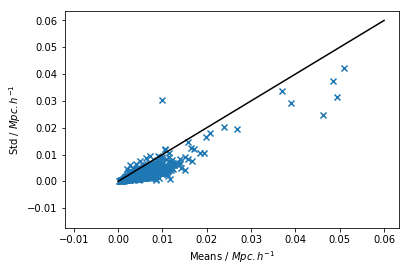

In [173]:
# Plots the means vs standard deviations of central galaxies, interpolated over the 62 tree.
means = pos_devs[0].mean(axis=1) # 0 = interpolation of 62 tree.  
stds = pos_devs[0].std(axis=1)
plt.figure()
plt.scatter(means, stds, marker="x")
plt.plot([0,0.06],[0,0.06], c="black")
plt.xlabel("Means / $Mpc.h^{-1}$")
plt.ylabel("Std / $Mpc.h^{-1}$")
plt.show()

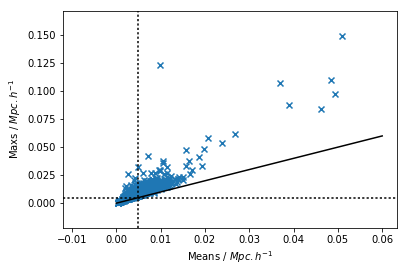

In [174]:
# Plots the means vs standard deviations of central galaxies, interpolated over the 62 tree.
means = pos_devs[0].mean(axis=1) # 0 = interpolation of 62 tree.  
maxs = pos_devs[0].max(axis=1)

plt.figure()
plt.scatter(means, maxs, marker="x")
plt.xlabel("Means / $Mpc.h^{-1}$")
plt.ylabel("Maxs / $Mpc.h^{-1}$")
plt.axvline(0.005,c="black",ls=":")
plt.axhline(0.005,c="black",ls=":")
plt.plot([0,0.06],[0,0.06], c="black")
plt.show()

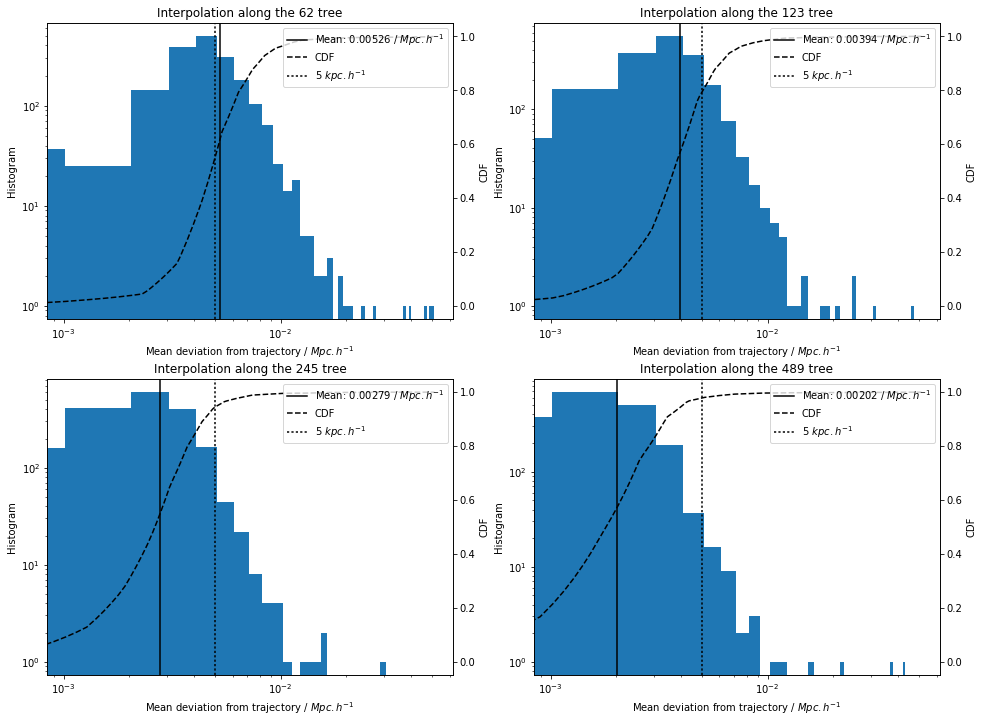

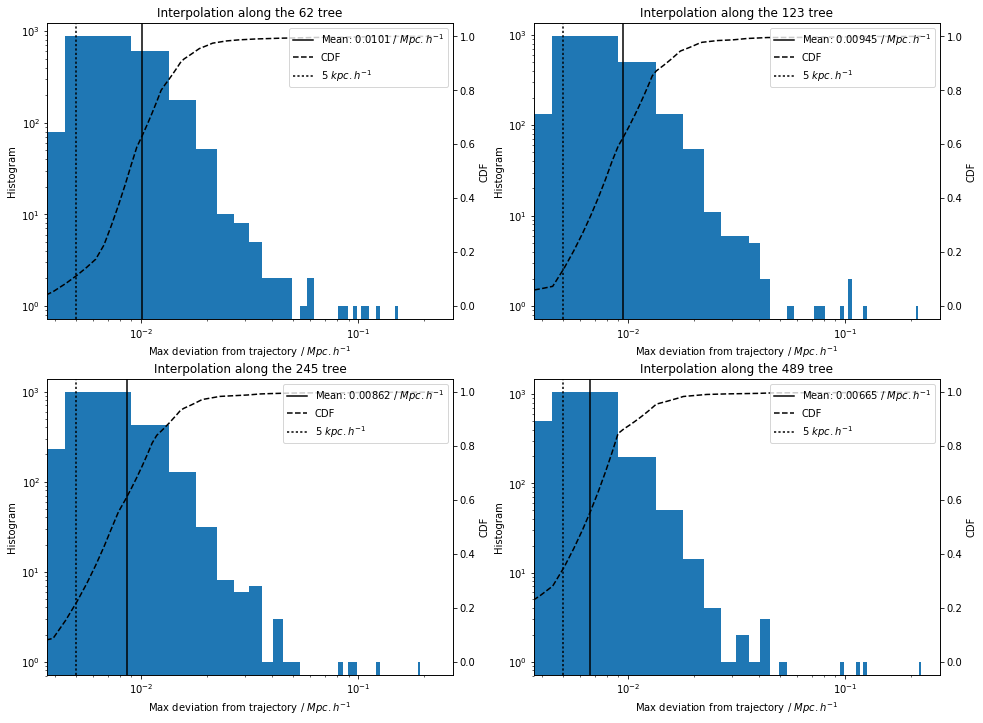

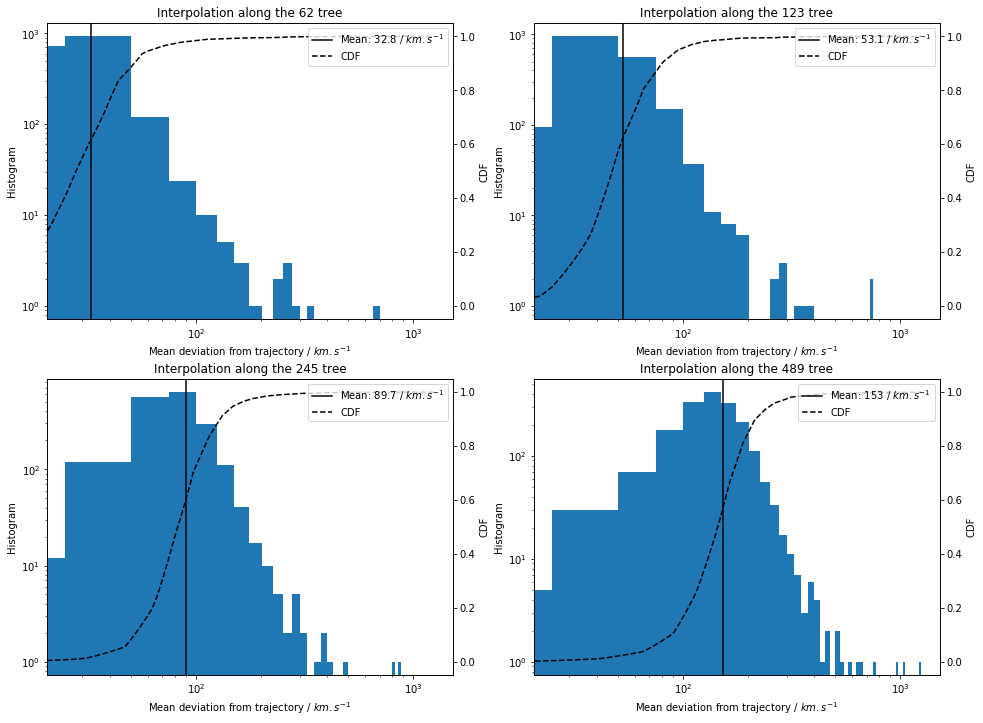

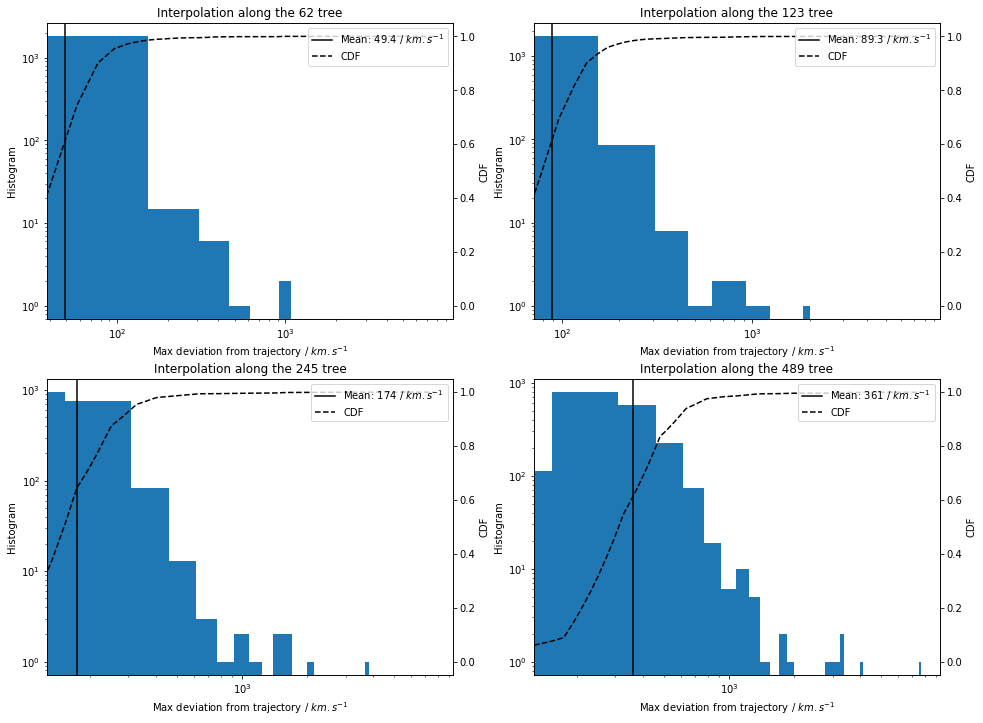

In [483]:
# Plot a histogram of the MEANS of the deviations of the POSITION, for interpolation using the 4 trees
plot_hists(pos_devs, titles=["Interpolation along the " + st + " tree" for st in ["62","123","245","489"]], 
           bins=50, use="Mean", logx=True, logy=True, plot_CDF=True)

# Plot a histogram of the MAX of the deviations of the POSITION, for interpolation using the 4 trees
plot_hists(pos_devs, titles=["Interpolation along the " + st + " tree" for st in ["62","123","245","489"]], 
           bins=50, use="Max", logx=True, logy=True, plot_CDF=True)

# Plot a histogram of the MEANS of the deviations of the VELOCITY, for interpolation using the 4 trees
plot_hists(vel_devs, titles=["Interpolation along the " + st + " tree" for st in ["62","123","245","489"]], 
           bins=50, use="Mean", logx=True, logy=True, plot_CDF=True, vel_unit=True)

# Plot a histogram of the MAX of the deviations of the VELOCITY, for interpolation using the 4 trees
plot_hists(vel_devs, titles=["Interpolation along the " + st + " tree" for st in ["62","123","245","489"]], 
           bins=50, use="Max", logx=True, logy=True, plot_CDF=True, vel_unit=True)


# Normalised dot product - see if velocity data makes sense

In [176]:
prod_avs = []
prod_maxs = []
prod_std = []
prod_mins = []
masses = []

# This is the normalsied dot-product.
# For each galaxy, go through the snapshots (in the 977 tree).  Find the unit direction from its position in one snapshot
# to it's position in the next.  Dot that with the unit direction of the velocity in the earlier snapshot.
# For each galaxy, store the mean, max, min, standard deviation of this products.  Also, the mass of the galaxy.
for gal in g.values():
    prods = np.zeros(16)
    for i in range(16):
        dist = np.array(gal[977][i+1][["xgal","ygal","zgal"]].iloc[0]) -  np.array(gal[977][i][["xgal","ygal","zgal"]].iloc[0]) #* interp.cosmo.h
        time = interp.cosmo.age(gal[977][i+1]["redshift"]) - interp.cosmo.age(gal[977][i]["redshift"])
        av_vel = dist / time.value
        vel = np.array(gal[977][i+1][["vxgal","vygal","vzgal"]].iloc[0])
        prods[i] = np.dot(av_vel/np.linalg.norm(av_vel), vel/np.linalg.norm(vel))
    # Save the mean, max, min, and standard devation of the products.  Also the mass of the galaxy.
    prod_avs.append(np.mean(prods))
    prod_maxs.append(np.max(prods))
    prod_mins.append(np.min(prods))
    prod_std.append(np.std(prods))
    masses.append(gal[977][0][["mhhalo"]].iloc[0])



In [ ]:
# This plots a figure of 4 scatter plots.  Halo Mass vs Mean/Standard Deviation/Min/Max of the normalised dot product of
# each galaxy's trajectory.
# The 20 'worst' ones (defined by the mean) are highlighted in red across the 4 plots.

colour = []
pickout=np.argsort(prod_avs)[:20]
for i in range(len(g)):
    if i in pickout:
        colour.append('r')
    else:
        colour.append('b')

plt.figure(figsize=(16,12))
ax1 = plt.subplot(221)
plt.scatter(prod_avs, masses, marker="x", c=colour)
ax1.set_yscale('log')
plt.xlabel("Mean $Cos(\Theta)$ along trajectory")
plt.ylabel("Halo Mass")

ax2 = plt.subplot(222)
plt.scatter(prod_std, masses, marker="x", c=colour)
ax2.set_yscale('log')
plt.xlabel("Std of $Cos(\Theta)$ along trajectory")
plt.ylabel("Halo Mass")

ax3 = plt.subplot(223)
plt.scatter(prod_maxs, masses, marker="x", c=colour)
ax3.set_yscale('log')
plt.xlabel("Max $Cos(\Theta)$ along trajectory")
plt.ylabel("Halo Mass")

ax4 = plt.subplot(224)
plt.scatter(prod_mins, masses, marker="x", c=colour)
ax4.set_yscale('log')
plt.xlabel("Min $Cos(\Theta)$ along trajectory")
plt.ylabel("Halo Mass")

plt.show()

In [ ]:
# Plots 4 plots on a figure.  First three are XY, YZ, XZ planes of the simulation.
# If plot_all is True, then it plots all central galaxies in the earliest snapshot of the 977 tree, 
# including those that have not been matched up.
# If plot_all is False, then it only plots the central galaxies that have been matched up,
# but the ones with the worst prod_av are highlighted.

plot_all = False


a = np.asarray([np.array(g.values()[i][977][16][["xgal","ygal","zgal"]].iloc[0]) for i in np.argsort(prod_avs)[:20]])


if plot_all:
    # This gives postion data for all the indentified central galaxies in the data
    b = np.asarray([np.array(gal[["xgal","ygal","zgal"]]) for i, gal in gal_type_list[0][977][16][0].iterrows()])
else:
    # This gives position data for all central galaxies in the 977 tree that have been matched up across the trees, 
    # and descendents found.
    b = np.asarray([np.array(gal[977][16][["xgal","ygal","zgal"]].iloc[0]) for gal in g.values()])

unit = "$Mpc.h^{-1}$"

plt.figure(figsize=(15,15))
plt.subplot(221, aspect='equal')
plt.scatter(b[:,0], b[:,1], marker="x")
if not plot_all: plt.scatter(a[:,0], a[:,1], marker="x", c='r')
plt.xlabel("xgal / "+unit)
plt.ylabel("ygal / "+unit)
plt.axis([0,125,0,125])

plt.subplot(222, aspect='equal')
plt.scatter(b[:,2], b[:,1], marker="x")
if not plot_all: plt.scatter(a[:,2], a[:,1], marker="x", c='r')
plt.xlabel("zgal / "+unit)
plt.ylabel("ygal / "+unit)
plt.axis([0,125,0,125])

plt.subplot(223, aspect='equal')
plt.scatter(b[:,0], b[:,2], marker="x")
if not plot_all: plt.scatter(a[:,0], a[:,2], marker="x", c='r')
plt.xlabel("xgal / "+unit)
plt.ylabel("zgal / "+unit)
plt.axis([0,125,0,125])
plt.show()

[400, 2254, 157753, 4786, 43520, 118943, 62135, 31245, 1162, 28539, 97113, 1255, 1, 115283, 100606, 1351, 143165, 127803, 2070, 5687]


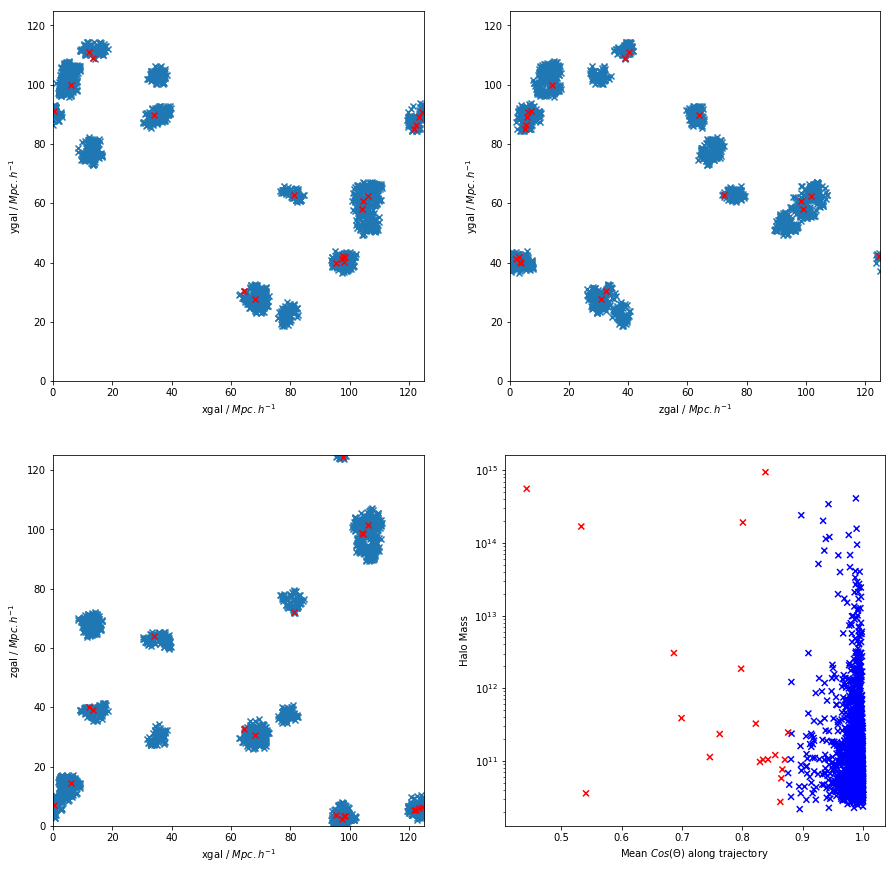

In [374]:
# Like the code above, but put in a loop to produce the figure for data in different ivolumes.
# Includes an extra figure - the mean of the normalised dot product against halo mass.

# For storing the data to be used later.
mass_store = []
prod_store = []

#The tree to use to find the dot products
tree = 977

for ivol in range(1):
   # b = []
    
    prod_avs = []
    masses = []
    gal_ref = []
    
    # Get galaxy data of centrals in the tree and i_vol
    new_g = get_all_matching_descendants_groups(merger_tree_list=[tree], sub_volumes=ivol, gal_type=0)
    
    snaps = snapshot_key_ref[tree]
    
    
    # Calculated the normalised dot product
    for ref, gal in new_g.items():
        gal_ref.append(ref)
        prods = np.zeros(len(snaps)-1)
        for i, ss in enumerate(snaps[:-1]):
            dist = np.array(gal[tree][snaps[i+1]][["xgal","ygal","zgal"]].iloc[0]) -  np.array(gal[tree][ss][["xgal","ygal","zgal"]].iloc[0]) #* interp.cosmo.h
            time = interp.cosmo.age(gal[tree][snaps[i+1]]["redshift"]) - interp.cosmo.age(gal[tree][ss]["redshift"])
            av_vel = dist / time.value
            vel = np.array(gal[tree][snaps[i+1]][["vxgal","vygal","vzgal"]].iloc[0])
            prods[i] = np.dot(av_vel/np.linalg.norm(av_vel), vel/np.linalg.norm(vel))
        
        # Store the masses and the normalised dot product averages
        prod_avs.append(np.mean(prods))
        masses.append(gal[tree][0][["mhhalo"]].iloc[0])
    prod_store.append(prod_avs)
    mass_store.append(masses) 
       
    
    # Create the figure in the same way as above.
    a = np.asarray([np.array(new_g.values()[i][tree][16][["xgal","ygal","zgal"]].iloc[0]) for i in np.argsort(prod_avs)[:20]])
    b = np.asarray([np.array(gal[tree][16][["xgal","ygal","zgal"]].iloc[0]) for gal in new_g.values()])
    
    unit = "$Mpc.h^{-1}$"
    plt.figure(figsize=(15,15))
    plt.subplot(221, aspect='equal')
    plt.scatter(b[:,0], b[:,1], marker="x")
    plt.scatter(a[:,0], a[:,1], marker="x", c='r')
    plt.xlabel("xgal / "+unit)
    plt.ylabel("ygal / "+unit)
    plt.axis([0,125,0,125])

    plt.subplot(222, aspect='equal')
    plt.scatter(b[:,2], b[:,1], marker="x")
    plt.scatter(a[:,2], a[:,1], marker="x", c='r')
    plt.xlabel("zgal / "+unit)
    plt.ylabel("ygal / "+unit)
    plt.axis([0,125,0,125])

    plt.subplot(223, aspect='equal')
    plt.scatter(b[:,0], b[:,2], marker="x")
    plt.scatter(a[:,0], a[:,2], marker="x", c='r')
    plt.xlabel("xgal / "+unit)
    plt.ylabel("zgal / "+unit)
    plt.axis([0,125,0,125])
   
    pickout=np.argsort(prod_avs)[:20]
    print [gal_ref[i] for i in pickout]
    colour=[]
    for i in range(len(prod_avs)):
        if i in pickout:
            colour.append('r')
        else:
            colour.append('b')
            
    # Also, add an extra panel for the mass distribution
    ax1 = plt.subplot(224)
    plt.scatter(prod_avs, masses, marker="x", c=colour)
    ax1.set_yscale('log')
    plt.xlabel("Mean $Cos(\Theta)$ along trajectory")
    plt.ylabel("Halo Mass")
    plt.show()

In [164]:
# The above code takes a long time to run for all the ivols.  Orininaly I forgot to save the data, but I had printed the
# outliers.  To save time, I recorded them here.

i0_outliers = [2338, 1659,  194, 2818, 3599, 4182, 1342, 3639, 2232, 2181,
               2430, 2535, 2495,    0,  912, 3293, 1571,  485, 2903, 2450]
i1_outliers = [3050, 1693, 1038, 2843, 2944,  911, 2979, 6969, 2383, 6268,
               4461, 1961, 5241, 2132, 5047,  378, 1949, 5061, 2223, 3100]
i2_outliers = [ 6567,  3665, 10382,  6906,  5385,  4181,  7806,  3861,  5618,  6141,
                5086,     1,   748,  1183,   800,  6664,  8356,  2592,  5521,  9074]
i3_outliers = [14007,  5493,  1041, 13018,  6731, 11007,  4498, 12702, 11617,  9049,
                  24,  3624,  2745, 11745,  9669, 14411,  3979,  1552, 12556,   116]
i4_outliers = [19874,   647, 18162, 21342,  9232,  4933,   817, 17870, 15587, 15224,
               21825, 22490, 12836, 20267, 20578, 22783, 17084, 17409,  3725, 21795]
i5_outliers = [29686,  6174, 26101, 14423, 31432, 25992,  3855,  3116, 16878, 10716,
               12726,  3590, 19174, 29943, 18838, 19155, 18461,   108,  5237, 18650]
i6_outliers = [ 2563,  1702, 22306,    30, 27880, 19333,  5093,  2066, 34062, 38104,
               34689, 10531, 13426, 11756, 30542,  7760, 26575,  9451, 31738,  6868]
i7_outliers = [ 7675, 37644, 39775, 30214,  5538,  2212, 40746,  6518, 38827,   619,
               22022,    45, 34089,  6707,  8151, 17338, 33352, 33479, 34807, 21014]

i_outliers = [i0_outliers,i1_outliers,i2_outliers,i3_outliers,i4_outliers,i5_outliers,i6_outliers,i7_outliers]

start 0
calc 0
start 1
calc 1
start 2
calc 2
start 3
calc 3
start 4
calc 4
start 5
calc 5
start 6
calc 6
start 7
calc 7


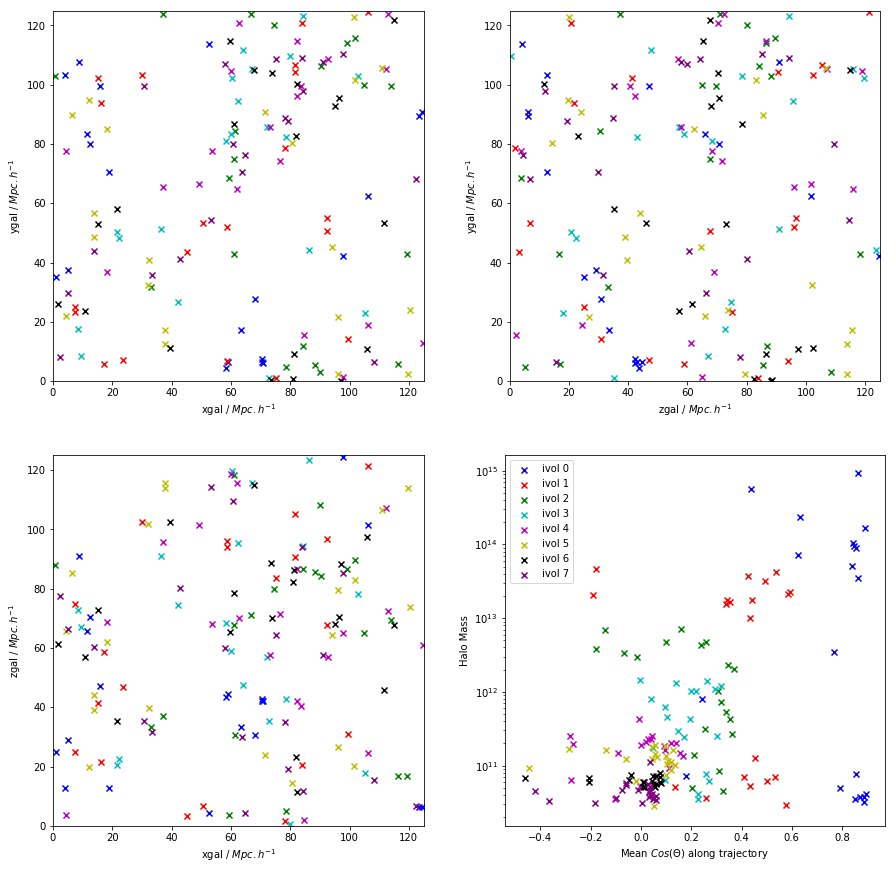

In [229]:
#  Plots the locations of the 20 worst galaxies for each ivol - on one figure

b = None
colours = ['b', 'r','g','c','m','y','k', "purple"]
#mass_store = []
#prod_store = []

# Set up figure
unit = "$Mpc.h^{-1}$"
plt.figure(figsize=(15,15))
ax1 = plt.subplot(221, aspect='equal')
plt.xlabel("xgal / "+unit)
plt.ylabel("ygal / "+unit)
plt.axis([0,125,0,125])
ax2 = plt.subplot(222, aspect='equal')
plt.xlabel("zgal / "+unit)
plt.ylabel("ygal / "+unit)
plt.axis([0,125,0,125])
ax3 = plt.subplot(223, aspect='equal')
plt.xlabel("xgal / "+unit)
plt.ylabel("zgal / "+unit)
plt.axis([0,125,0,125])
ax4 = plt.subplot(224)
ax4.set_yscale('log')
plt.xlabel("Mean $Cos(\Theta)$ along trajectory")
plt.ylabel("Halo Mass") 

for ivol in range(8):
   # b = []
    print 'start', ivol
    tree = 123

    prod_avs = []

    masses = []
    new_g = get_all_matching_descendants_groups(merger_tree_list=[tree], sub_volumes=ivol, gal_type=0)
    print 'calc', ivol
    snaps = [0,8,16]
    
    # Get the normalised dot product, and halo mass, for each Outlier galaxy.  (No need to do them all)
    for index in i_outliers[ivol]:
        gal = new_g.values()[index]
        prods = np.zeros(2)
        for i, ss in enumerate(snaps[:-1]):
            dist = np.array(gal[tree][snaps[i+1]][["xgal","ygal","zgal"]].iloc[0]) -  np.array(gal[tree][ss][["xgal","ygal","zgal"]].iloc[0]) #* interp.cosmo.h
            time = interp.cosmo.age(gal[tree][snaps[i+1]]["redshift"]) - interp.cosmo.age(gal[tree][ss]["redshift"])
            av_vel = dist / time.value
            vel = np.array(gal[tree][snaps[i+1]][["vxgal","vygal","vzgal"]].iloc[0])
            #prod.append(np.dot(av_vel/np.linalg.norm(av_vel), vel/np.linalg.norm(vel)    ))
            prods[i] = np.dot(av_vel/np.linalg.norm(av_vel), vel/np.linalg.norm(vel))
        prod_avs.append(np.mean(prods))

        masses.append(gal[tree][0][["mhhalo"]].iloc[0])
    #prod_store.append(prod_avs)
   # mass_store.append(masses)       

    a = np.asarray([np.array(new_g.values()[i][tree][16][["xgal","ygal","zgal"]].iloc[0]) for i in i_outliers[ivol]])
    

    # Plot the data
    ax1.scatter(a[:,0], a[:,1], marker="x", c=colours[ivol])

    ax2.scatter(a[:,2], a[:,1], marker="x", c=colours[ivol])

    ax3.scatter(a[:,0], a[:,2], marker="x", c=colours[ivol])
    
    ax4.scatter(prod_avs, masses, marker="x", c=colours[ivol], label= ("ivol " + str(ivol)))
ax4.legend(loc=2)
plt.show()

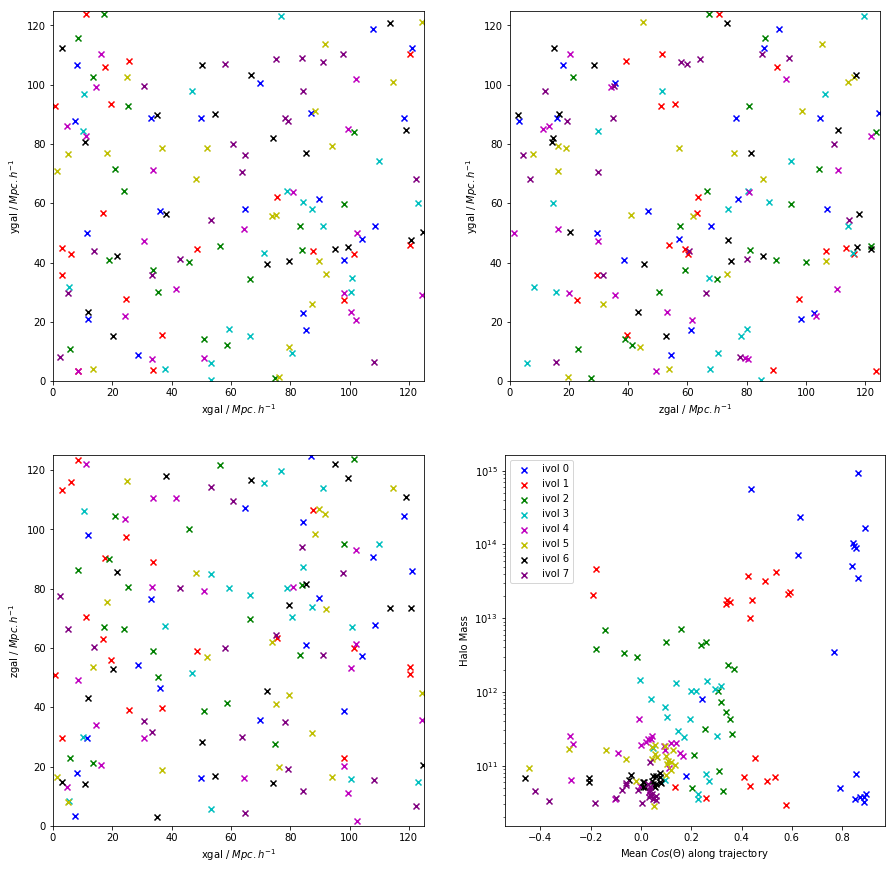

In [192]:
# The same as above, but this time it uses data saved from above.


b = None
colours = ['b', 'r','g','c','m','y','k', "purple"]

unit = "$Mpc.h^{-1}$"
plt.figure(figsize=(15,15))
ax1 = plt.subplot(221, aspect='equal')
plt.xlabel("xgal / "+unit)
plt.ylabel("ygal / "+unit)
plt.axis([0,125,0,125])
ax2 = plt.subplot(222, aspect='equal')
plt.xlabel("zgal / "+unit)
plt.ylabel("ygal / "+unit)
plt.axis([0,125,0,125])
ax3 = plt.subplot(223, aspect='equal')
plt.xlabel("xgal / "+unit)
plt.ylabel("zgal / "+unit)
plt.axis([0,125,0,125])
ax4 = plt.subplot(224)
ax4.set_yscale('log')
plt.xlabel("Mean $Cos(\Theta)$ along trajectory")
plt.ylabel("Halo Mass")    
for ivol in range(8):

    tree = 123

    prod_avs = prod_store[ivol]
    masses = mass_store[ivol]
    
   

    a = np.asarray([np.array(g.values()[i][tree][16][["xgal","ygal","zgal"]].iloc[0]) for i in i_outliers[ivol]])
    #b = np.asarray([np.array(gal[tree][16][["xgal","ygal","zgal"]].iloc[0]) for gal in g.values()])
    

    
    ax1.scatter(a[:,0], a[:,1], marker="x", c=colours[ivol])

    ax2.scatter(a[:,2], a[:,1], marker="x", c=colours[ivol])

    ax3.scatter(a[:,0], a[:,2], marker="x", c=colours[ivol])
    
    ax4.scatter(prod_avs, masses, marker="x", c=colours[ivol], label= ("ivol " + str(ivol)))
ax4.legend(loc=2)
plt.show()

# Misc Stuff

## Older deviations

In [ ]:
# Get deviations for all galaxies, using different trees for interpolation

devs_62 = []
devs_123 = []
devs_245 = []
devs_489 = []
for i, key in enumerate(g.keys()):
    if i % 50 == 0:
        print i
    item = g[key]
    devs_62.append(find_cen_deviation(item, tree_for_interpolation = 62, snapshots_for_statistics=range(16)))
    devs_123.append(find_cen_deviation(item, tree_for_interpolation = 123, snapshots_for_statistics=range(16)))
    devs_245.append(find_cen_deviation(item, tree_for_interpolation = 245, snapshots_for_statistics=range(16)))
    devs_489.append(find_cen_deviation(item, tree_for_interpolation = 489, snapshots_for_statistics=range(16)))
    

a_devs_62 = np.asarray(devs_62)[:,0,:] # Remove velocity data - only want positions
a_devs_123 = np.asarray(devs_123)[:,0,:]
a_devs_245 = np.asarray(devs_245)[:,0,:]
a_devs_489 = np.asarray(devs_489)[:,0,:]

In [ ]:
# Print the means of the deviation in each tree.
# Also, the worst galaxy at each point, in each tree

for devs in [a_devs_62, a_devs_123, a_devs_245, a_devs_489]:
    print devs.mean(), devs.argmax(axis=0)

# Velocity Study

In [ ]:
# Compare the average of the initial/final velocities, and the required average velocity to move between snapshots

av_vel = []
req_vel = []
unit_scale = (1 * u.km / u.s).to(u.Mpc / u.Gyr).value  
for gal in g.values():
    # Distance moved
    dist = ( np.array(gal[977][16][["xgal","ygal","zgal"]].iloc[0]) -  np.array(gal[977][0][["xgal","ygal","zgal"]].iloc[0]) )/ interp.cosmo.h
    # Time taken
    time = interp.cosmo.age(gal[977][16]["redshift"]) - interp.cosmo.age(gal[977][0]["redshift"])
    # Speed required
    req_vel.append(np.linalg.norm(dist / time.value))
    
    #Comoving velocity 1
    vel1 =  unit_scale*(np.array(gal[977][16][["vxgal","vygal","vzgal"]].iloc[0]) / interp.cosmo.scale_factor(gal[977][16][["redshift"]].iloc[0]))
    #Comoving velocity 1 
    vel2 =  unit_scale*(np.array(gal[977][0][["vxgal","vygal","vzgal"]].iloc[0]) / interp.cosmo.scale_factor(gal[977][0][["redshift"]].iloc[0]))
    #Average comoving velocity
    av_vel.append(np.linalg.norm((vel1 + vel2)/2))


In [ ]:
# Plot the above data
plt.figure()
plt.plot([0,2],[0,2], c="black")
plt.scatter(req_vel, av_vel)
plt.xlabel("Required Velocity")
plt.ylabel("Average Velocity")
plt.show()

np.average(np.divide(req_vel, av_vel))

In [ ]:
# Plot the first central/satellite pair

c,s = satellite_central_groups[0]

for tree in [62,123,245,489]:
    __make_satellite_plot(c,s[0], tree_for_interp=tree)


# View a Galaxy

In [ ]:
# Print the data for a galaxy, in a given tree


key, i = g.items()[83]      #galaxy 83
pd.concat(i[977].values())  #977 tree

In [ ]:
# Interesting ones:  0, 45, 654, 1716, 1620, 1589, 1162

# a whole new level of interesting: 1620, 1047, 878, 1090, 272,  403

#1047,  1698

key, item = g.items()[83]

item = item.copy()


if False:
    # Get deviations and print them
    d1, vd1 = find_cen_deviation(item, tree_for_interpolation = 62, snapshots_for_statistics=range(16))
    d2, vd2  = find_cen_deviation(item, tree_for_interpolation = 123, snapshots_for_statistics=range(16))
    d3, vd3 = find_cen_deviation(item, tree_for_interpolation = 245, snapshots_for_statistics=range(16))
    d4, vd4  = find_cen_deviation(item, tree_for_interpolation = 489, snapshots_for_statistics=range(16))

    for dn in [d1,d2,d3,d4]:
        print "sum: ",sum(dn),", max: ", max(dn),", mean: ", np.average(dn)

    print ""

    
# Either:  Print different plots for with interpolation in the same tree, or the same plot repeated for interpolation
# within different trees
if False:
    for tree in required_snapshot_ids.keys()[:-1]:
       # __make_central_plot_vel_space(item, tree)
       # __make_central_vel_plot(item, tree)
        __make_central_plot(item, tree)
else:
    __make_central_vel_plot(item, 489)
    __make_central_plot(item, 489)
    __make_central_plot_vel_space(item, 489)




# Find Dulplicates

In [ ]:
# Find dulplicate type 2 galaxies

print len(gal_type_list[2][62][0][0]["SubhaloIndex"])
print len(np.unique(gal_type_list[2][62][0][0]["SubhaloIndex"]))
li = list(gal_type_list[2][62][0][0]["SubhaloIndex"])
dulps =[]
while len(li)>0:
    nxt = li.pop()
    if nxt in li:
        dulps.append(nxt)

In [ ]:
dulp_gals = gal_type_list[2][62][0][0].iloc[np.where(gal_type_list[2][62][0][0]["SubhaloIndex"] == dulps[0])[0]]

In [ ]:
# Get a dulplicate galaxy's history

chain = pd.DataFrame(dulp_gals.iloc[[0]])

for i, ss in enumerate(snapshot_key_ref[62]):
    if ss == 0: continue
    chain = pd.concat((chain, 
       gal_type_list[2][62][ss][0].iloc[np.where(gal_type_list[2][62][ss][0]["DescendantID"] == chain["GalaxyID"].iloc[i-1])[0]]))

chain

# Comparing different cubic interpolations

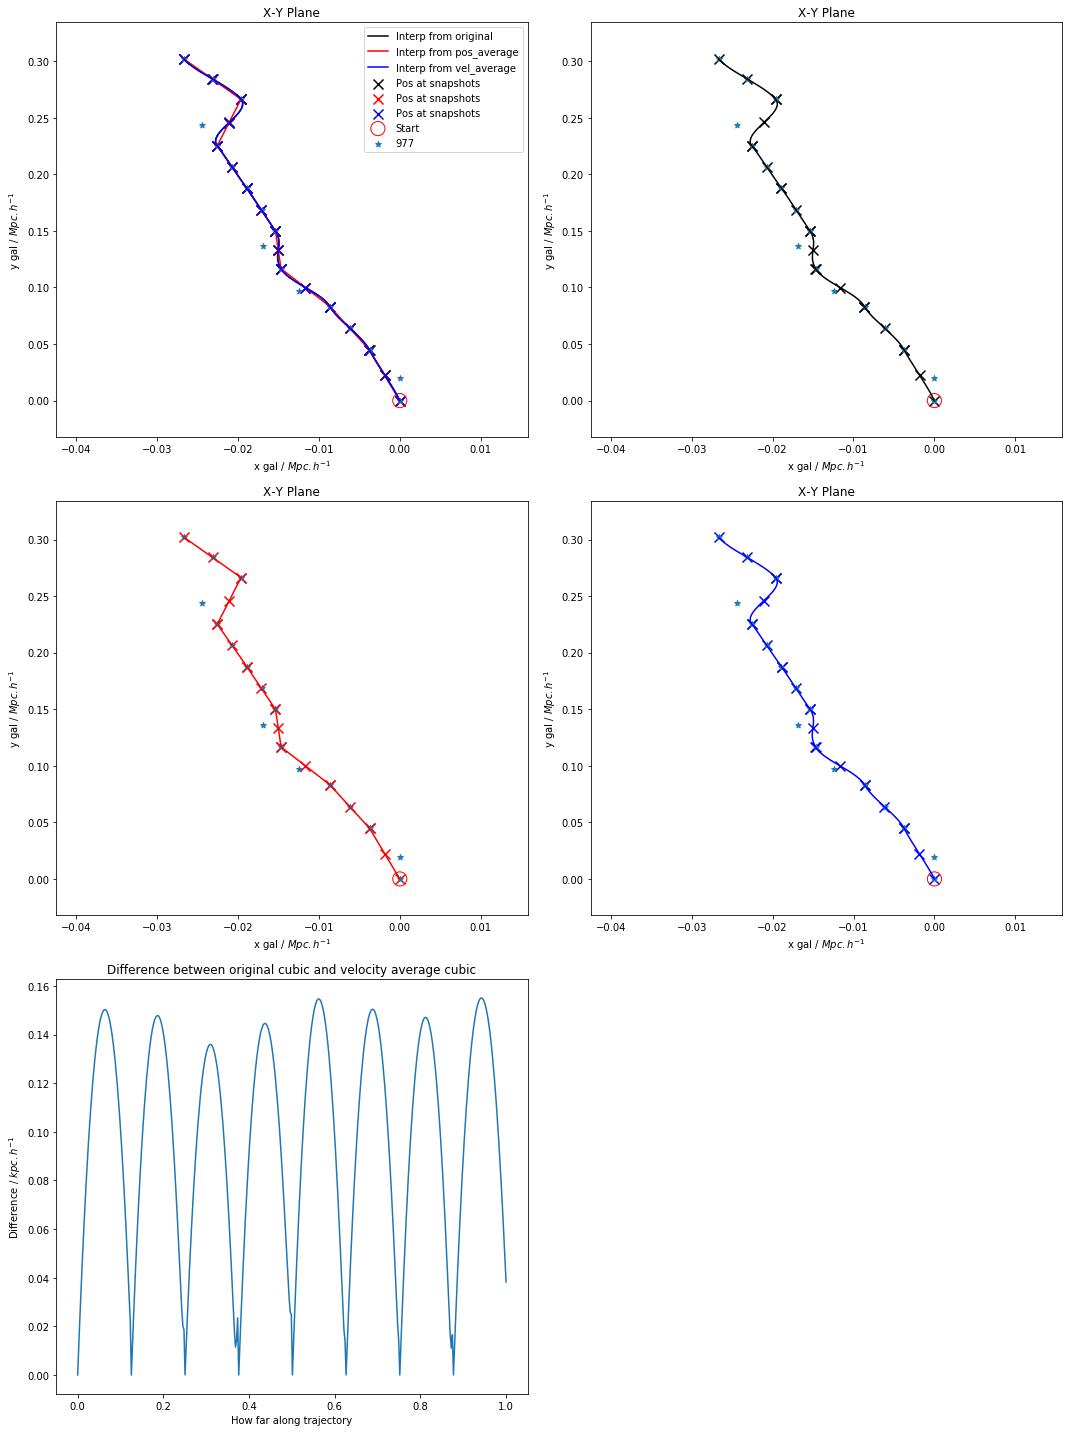

In [294]:
# Interesting ones:  0, 45, 654, 1716, 1620, 1589, 1162

# a whole new level of interesting: 1620, 1047, 878, 1090, 272,  403

#1047,  1698

test_cen_interp(g.values()[45])

#test_cen_interp(g.values()[1], 245, "\"The Good\"") #28
#test_cen_interp(g.values()[45], 245, "\"The bad\"")
#test_cen_interp(g.values()[1090], 245, "\"The Ugly\"")

In [292]:
cubic_devs_245 = []
cubic_vdevs_245 = []

linear_devs_245 = []
linear_vdevs_245 = []

# Get deviations of all the galaxies for different interpolations
for key, item in g.items():
    cub = find_cen_deviation(item, tree_for_interpolation = 245, snapshots_for_statistics=range(16))
    lin = find_cen_deviation(item, tree_for_interpolation = 245, snapshots_for_statistics=range(16), interp_to_use=pos_av_interp)
    
    cubic_devs_245.append(cub[0])
    cubic_vdevs_245.append(cub[1])
    
    linear_devs_245.append(lin[0])
    linear_vdevs_245.append(lin[1])
    







0



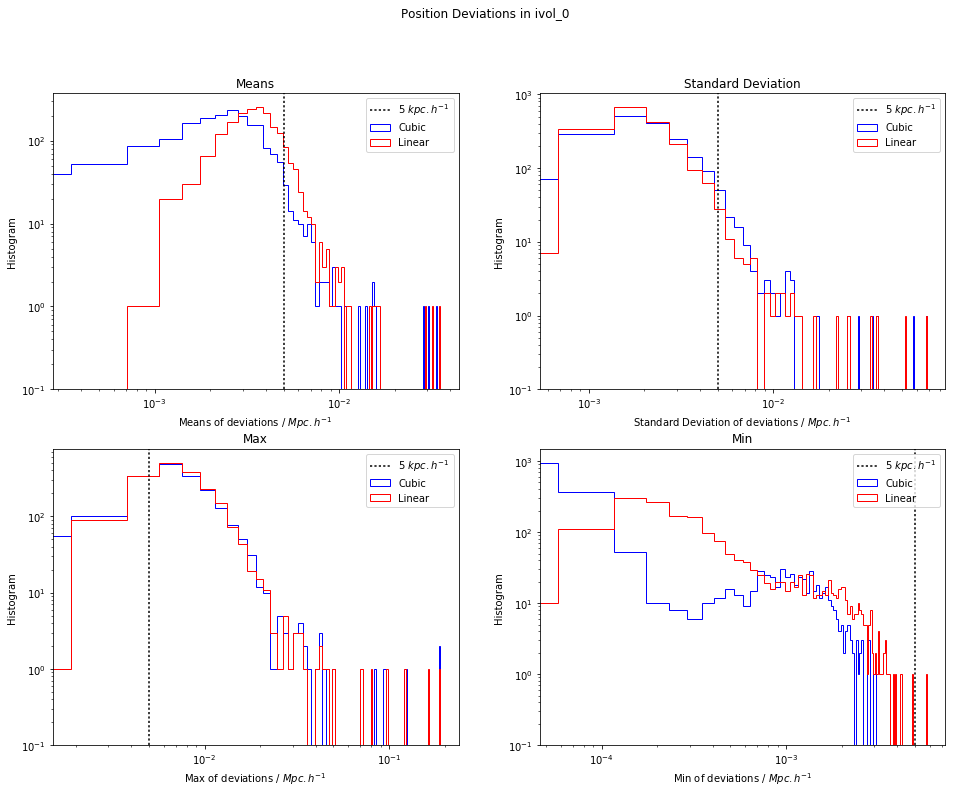

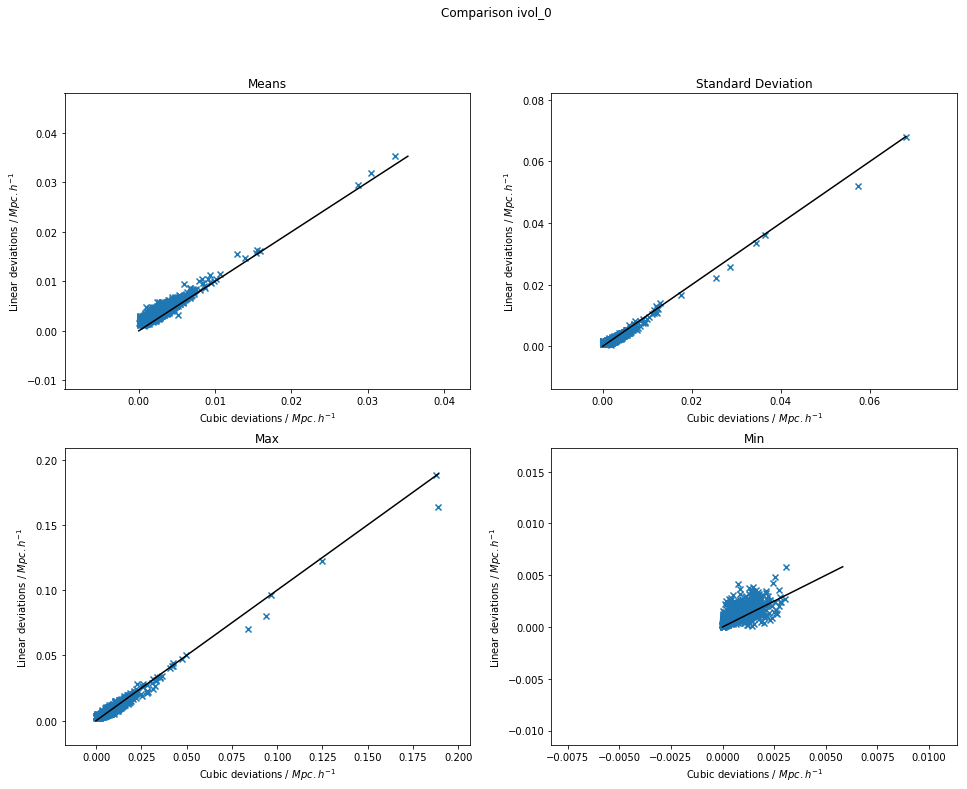

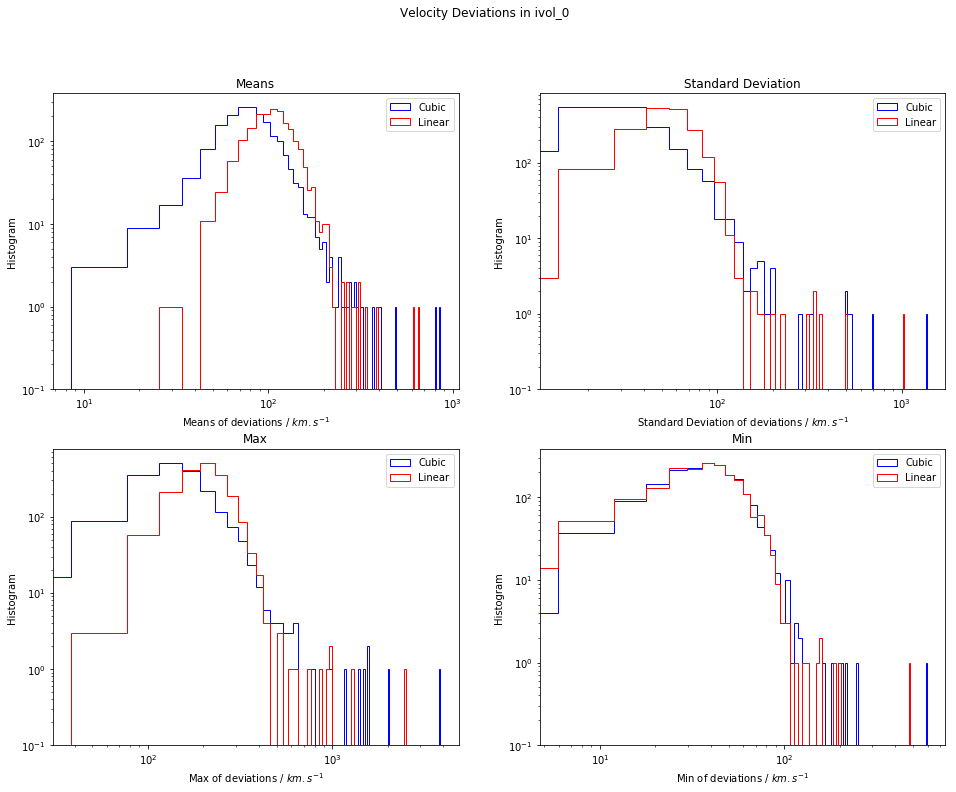






1



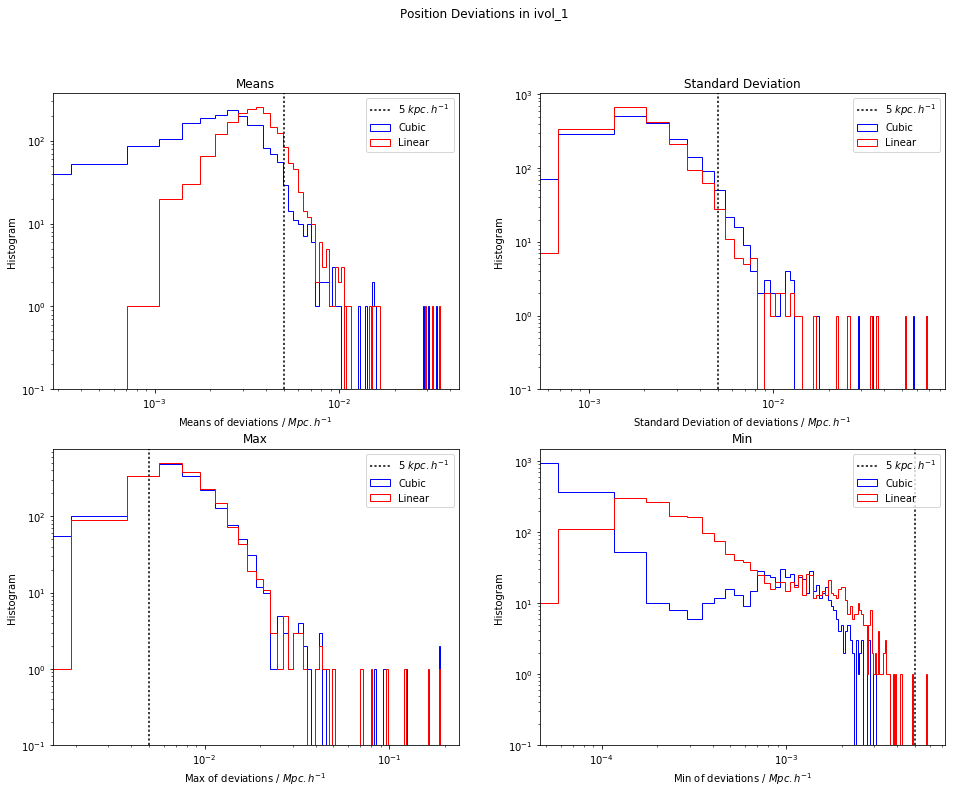

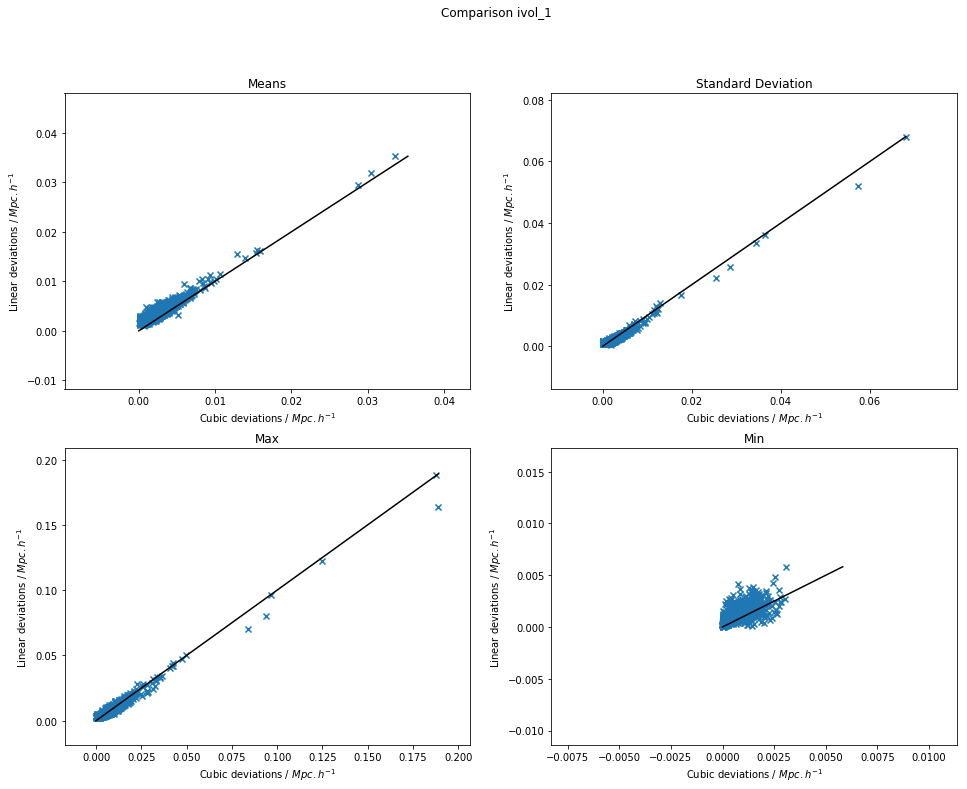

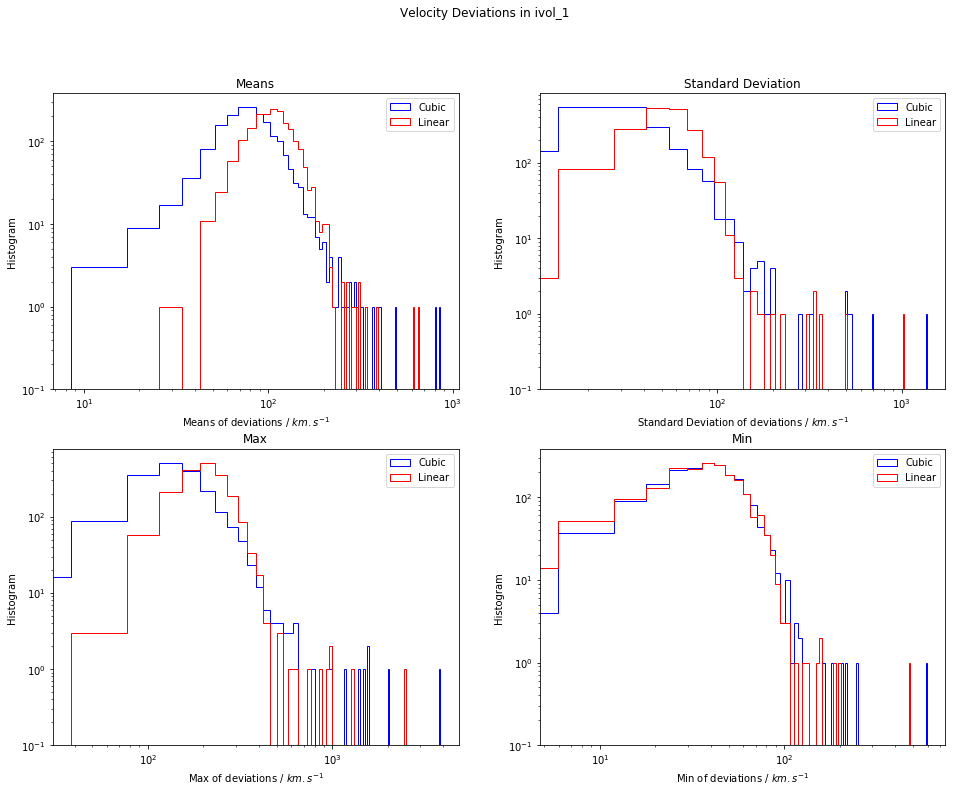

In [30]:
import scipy

bins = 100

logy = True
logx = True
unit = ""
xlab = ""



lbl = ["Cubic", "Linear"]
calc = ["Means", "Standard Deviation", "Max", "Min"]


cubic_devs_245 = []
cubic_vdevs_245 = []

linear_devs_245 = []
linear_vdevs_245 = []
for ivolume in [0,1]:#[5,6,7,1,3,4]:
    gal_list_for_now = get_all_matching_descendants_groups(merger_tree_list=[245, 977], sub_volumes=ivolume, gal_type=0)
    
    print ""
    print ""
    print ""
    print ""
    print ""
    print ivolume
    print ""
    
    
    for key, item in gal_list_for_now.items():
        cub = find_cen_deviation(item, tree_for_interpolation = 245, snapshots_for_statistics=range(16))
        lin = find_cen_deviation(item, tree_for_interpolation = 245, snapshots_for_statistics=range(16), interp_to_use=pos_av_interp)

        cubic_devs_245.append(cub[0])
        cubic_vdevs_245.append(cub[1])

        linear_devs_245.append(lin[0])
        linear_vdevs_245.append(lin[1])


    fig = plt.figure(figsize=(16,12))
    fig.suptitle("Position Deviations in ivol_%d" %ivolume)
    for plot, func in enumerate([np.mean, np.std, np.max, np.min]):
        ax1 = plt.subplot((221+plot))   

        to_use = []

        to_use.append(func(cubic_devs_245, axis=1))
        to_use.append(func(linear_devs_245, axis=1))

        rang = (0,np.max(to_use))


        for i, col in enumerate(["blue", "red"]):
            plt.hist(to_use[i], bins=bins, normed=False, range=rang, log=logy, histtype='step', color=col, label=lbl[i])
            #m = np.mean(to_use[i])
            #mean_line = ax1.axvline(m, label=("Mean: %.3G / " % (m) + unit), c=col)

        res_line = ax1.axvline(0.005, c="black", ls=":", label="5 $kpc.h^{-1}$")
        plt.title(calc[plot])
        ax1.set_xlabel((calc[plot] + " of deviations / $Mpc.h^{-1}$"))
        ax1.set_ylabel('Histogram')

        #legend_lines = [mean_line]

        plt.legend(loc=1) #handles=legend_lines,

        if logx: 
            ax1.set_xscale('log')

    #############################################
    fig = plt.figure(figsize=(16,12))
    fig.suptitle("Comparison ivol_%d" %ivolume)
    for plot, func in enumerate([np.mean, np.std, np.max, np.min]):
        ax1 = plt.subplot((221+plot))   

        to_use = []

        to_use.append(func(cubic_devs_245, axis=1))
        to_use.append(func(linear_devs_245, axis=1))

        rang = (0,np.max(to_use))


        plt.scatter(to_use[0], to_use[1], marker="x")
        
        plt.plot([0,rang[1]], [0, rang[1]], c='black')
        
        plt.title(calc[plot])
        ax1.set_xlabel("Cubic deviations / $Mpc.h^{-1}$")
        ax1.set_ylabel("Linear deviations / $Mpc.h^{-1}$")

    
    
    ##################################################################
    
    fig = plt.figure(figsize=(16,12))
    fig.suptitle("Velocity Deviations in ivol_%d" %ivolume)
    for plot, func in enumerate([np.mean, np.std, np.max, np.min]):
        ax1 = plt.subplot((221+plot))   

        to_use = []

        to_use.append(func(cubic_vdevs_245, axis=1))
        to_use.append(func(linear_vdevs_245, axis=1))

        rang = (0,np.max(to_use))


        for i, col in enumerate(["blue", "red"]):
            plt.hist(to_use[i], bins=bins, normed=False, range=rang, log=logy, histtype='step', color=col, label=lbl[i])
            #m = np.mean(to_use[i])
            #mean_line = ax1.axvline(m, label=("Mean: %.3G / " % (m) + unit), c=col)


        plt.title(calc[plot])
        ax1.set_xlabel((calc[plot] + " of deviations / $km.s^{-1}$"))
        ax1.set_ylabel('Histogram')

        #legend_lines = [mean_line]

        plt.legend(loc=1) #handles=legend_lines,

        if logx: 
            ax1.set_xscale('log')


    plt.show()

# Plot with surroundings

In [373]:
new_g = get_all_matching_descendants_groups(merger_tree_list=[245, 977], sub_volumes=0, gal_type=0)

In [375]:
gal_ref[np.argsort(prod_avs)[-1]]

209080

0.800054974825
Nearby galaxies:  [1162, 1164, 1166, 1169, 1173, 1175, 1176, 1217, 1220, 1227, 1234, 1239, 1244, 1250, 1255, 58662, 1322, 1361, 1367, 1368, 24817, 110854, 91787, 198837, 117115, 133604, 52339, 61261, 184295, 198826, 63989, 104966, 129600, 1230, 130912]


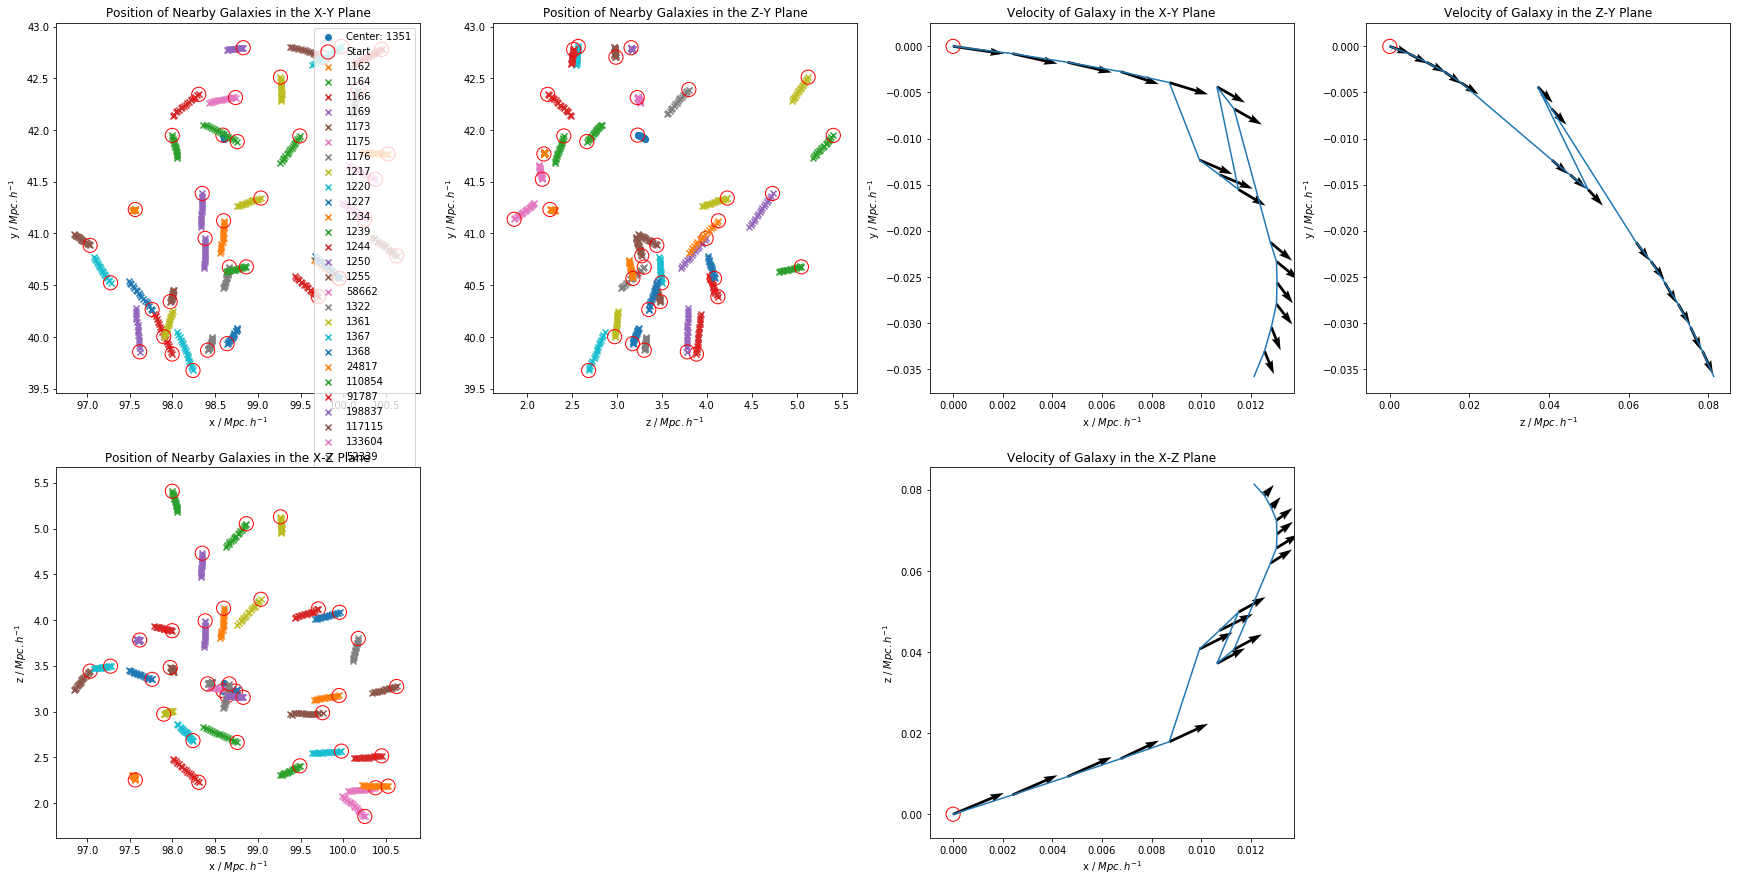

0.858215398415
Nearby galaxies:  [123195, 74282, 41607, 703, 735, 795, 84274, 166467, 76685, 118343, 102271, 77714, 45017, 687, 159999, 160002, 726, 128088, 153037, 53935, 55478, 162260, 96787, 203324, 23419, 212218, 106163, 24340, 113300]


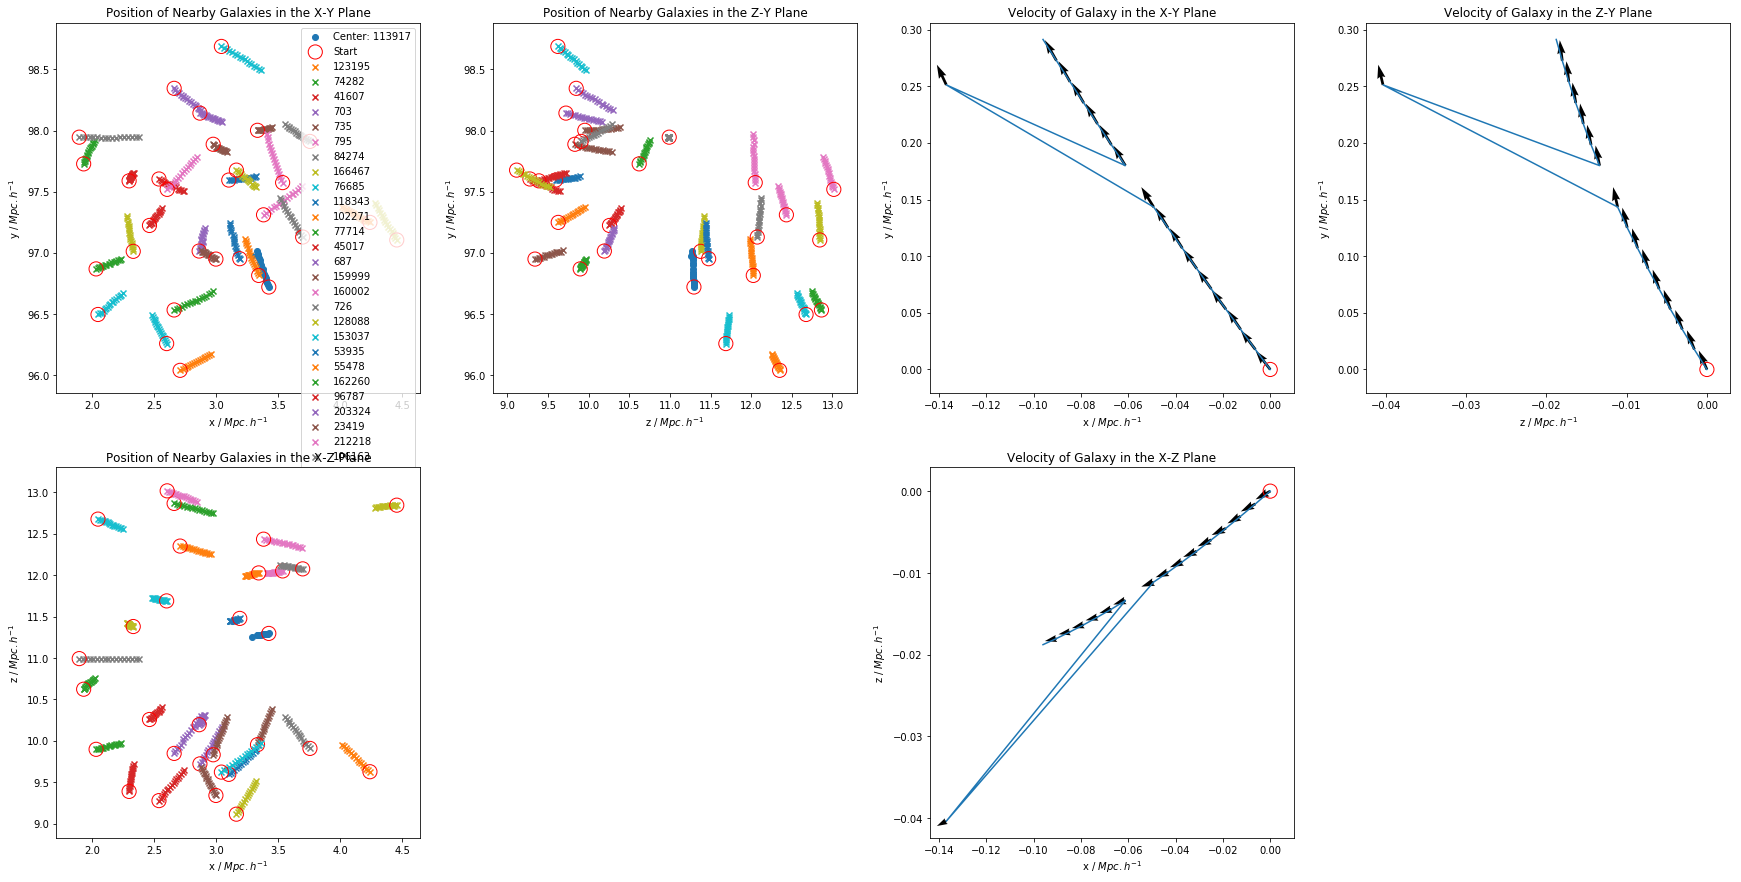

0.868275383183
Nearby galaxies:  [139636, 43009, 45109, 4166, 4178, 4911, 4912, 4929, 4935, 4923, 78854, 5805, 5822, 80292, 188165, 122733]


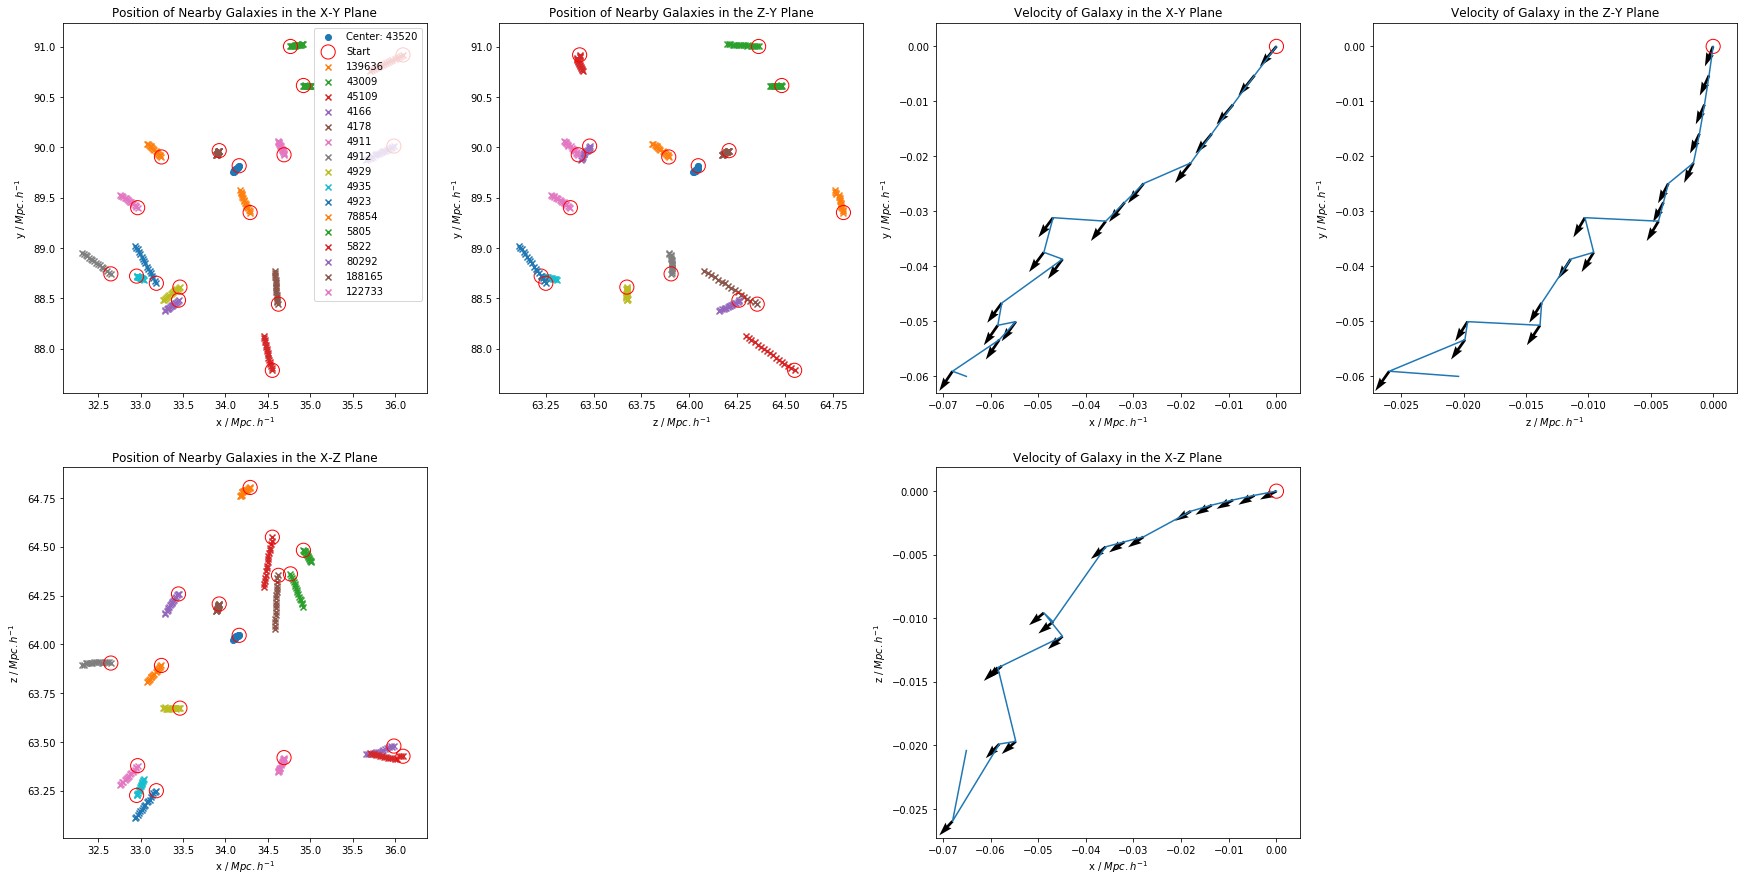

0.956696110754
Nearby galaxies:  [139278, 407, 419, 439, 445, 453, 463, 472, 473, 482, 485, 487, 504, 538, 561, 585, 603, 608, 49782, 637, 100537, 92837, 117619, 117675, 116566, 159247, 151286, 28596, 69656, 111426, 103549, 137428, 104742, 88882, 64490, 98242]


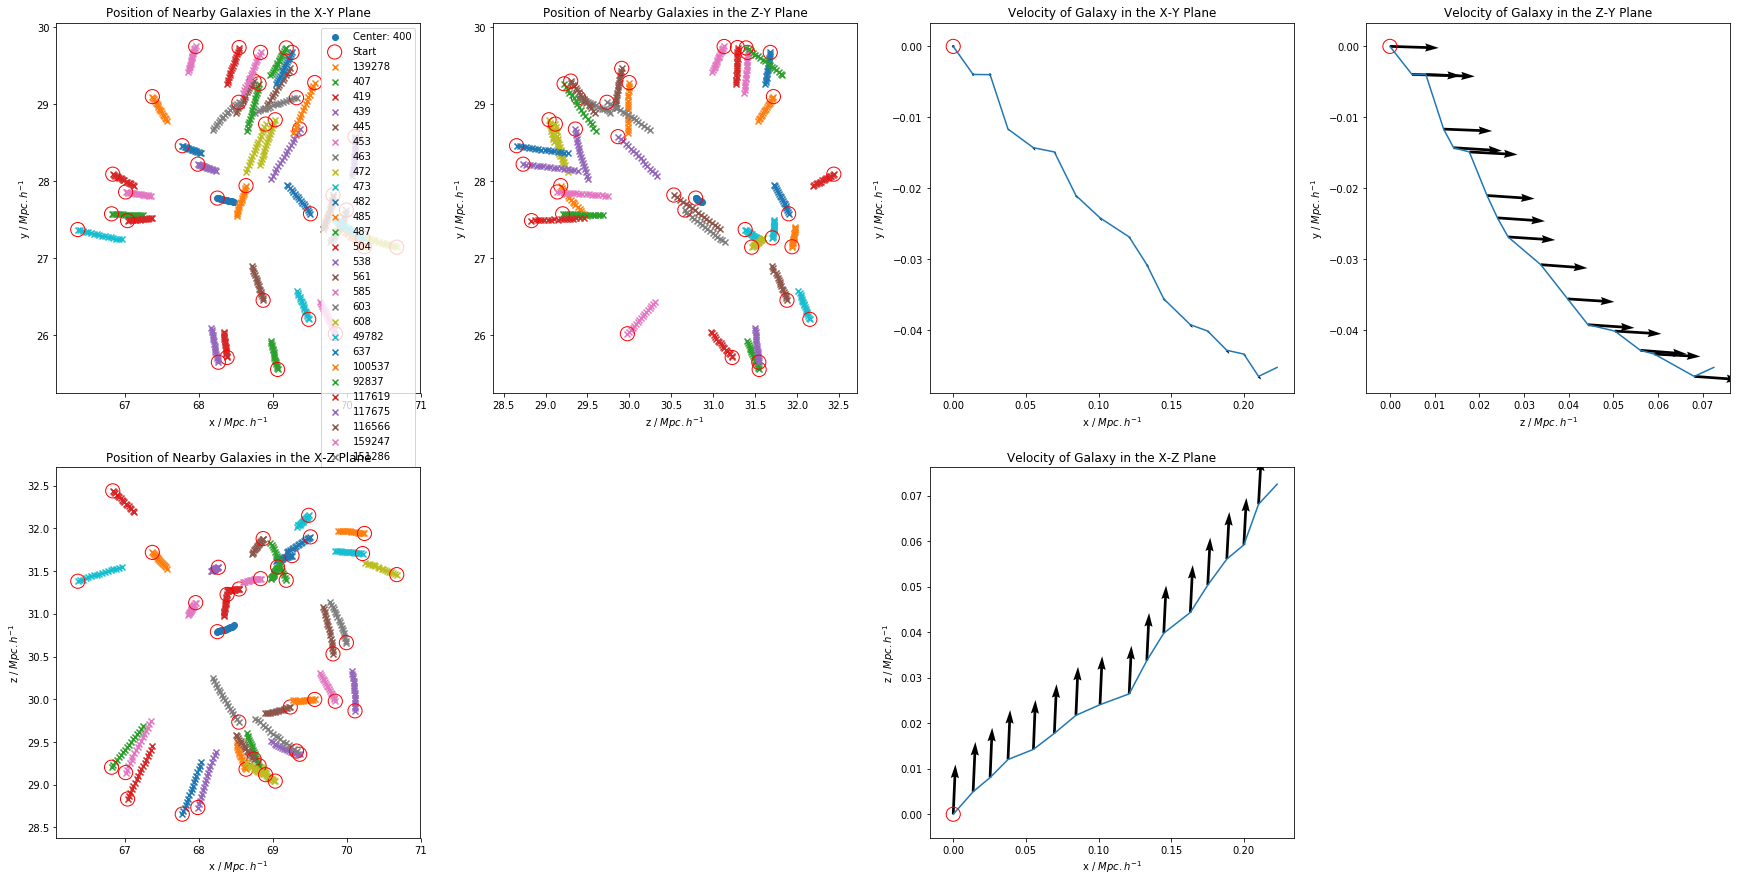

0.959768855086
Nearby galaxies:  [82099, 4791, 142693, 184556, 127257, 4850, 4789, 4790, 4793, 4797, 4798, 4799, 4836, 70442, 86938, 185681, 7200, 163468, 131024]


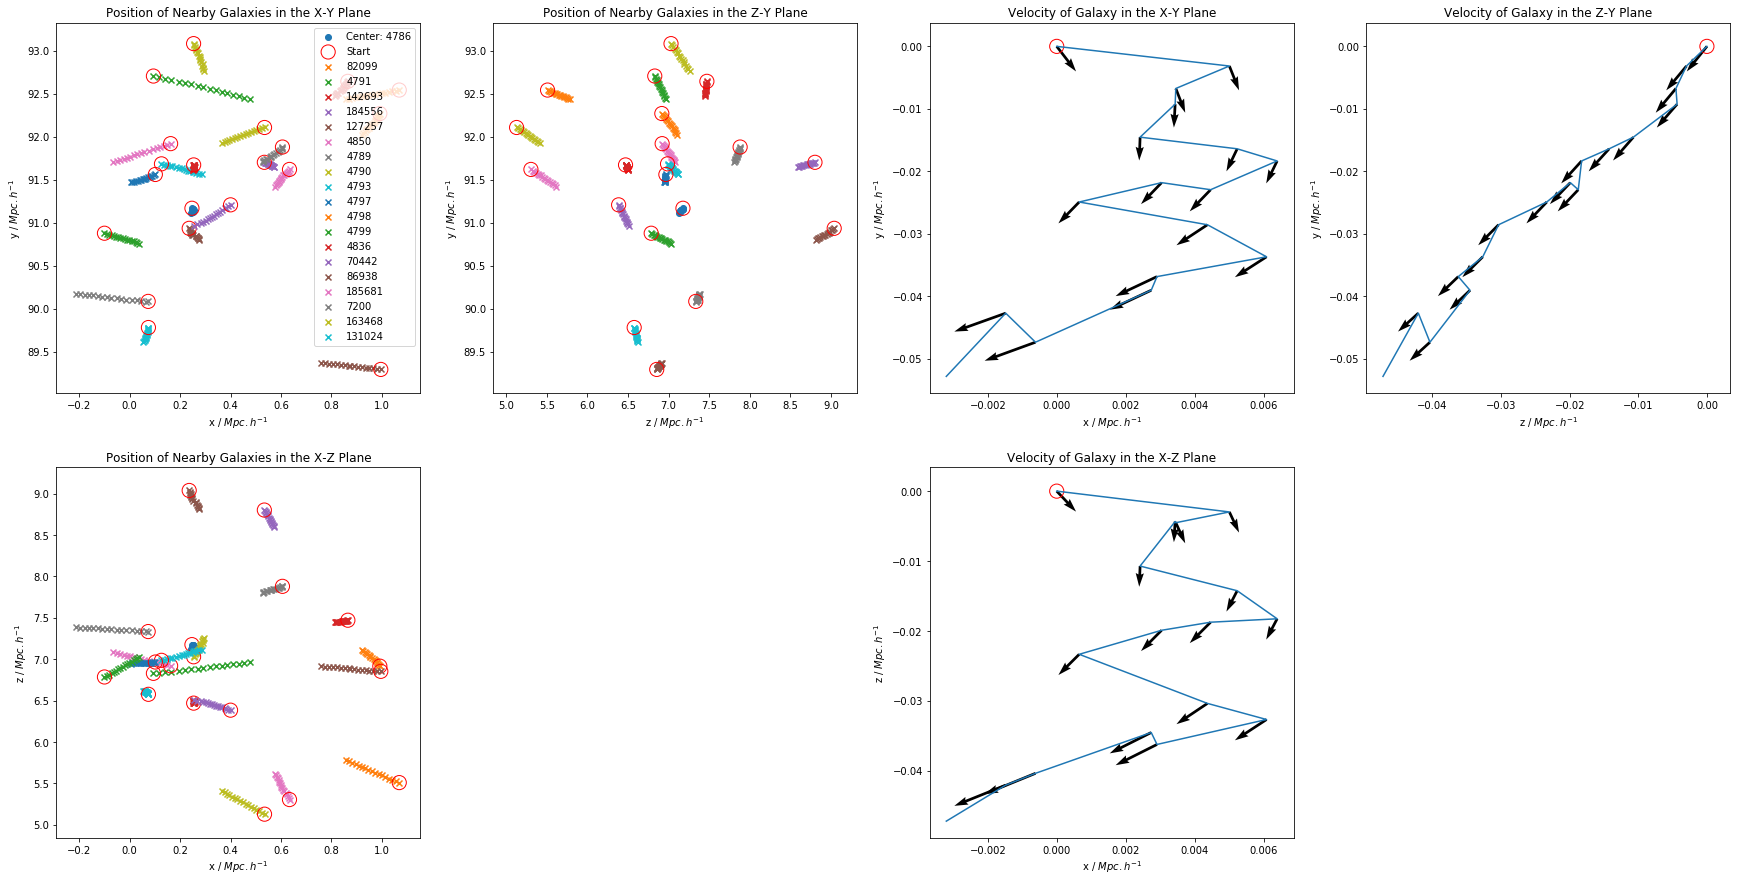

1.09157749101
Nearby galaxies:  [123459, 53426, 1163, 1166, 1167, 1173, 1193, 1250, 83218, 1345, 1367, 1368, 75393, 83707, 52333, 53427, 110802, 86269, 103584, 112312, 87780, 121335, 101800]


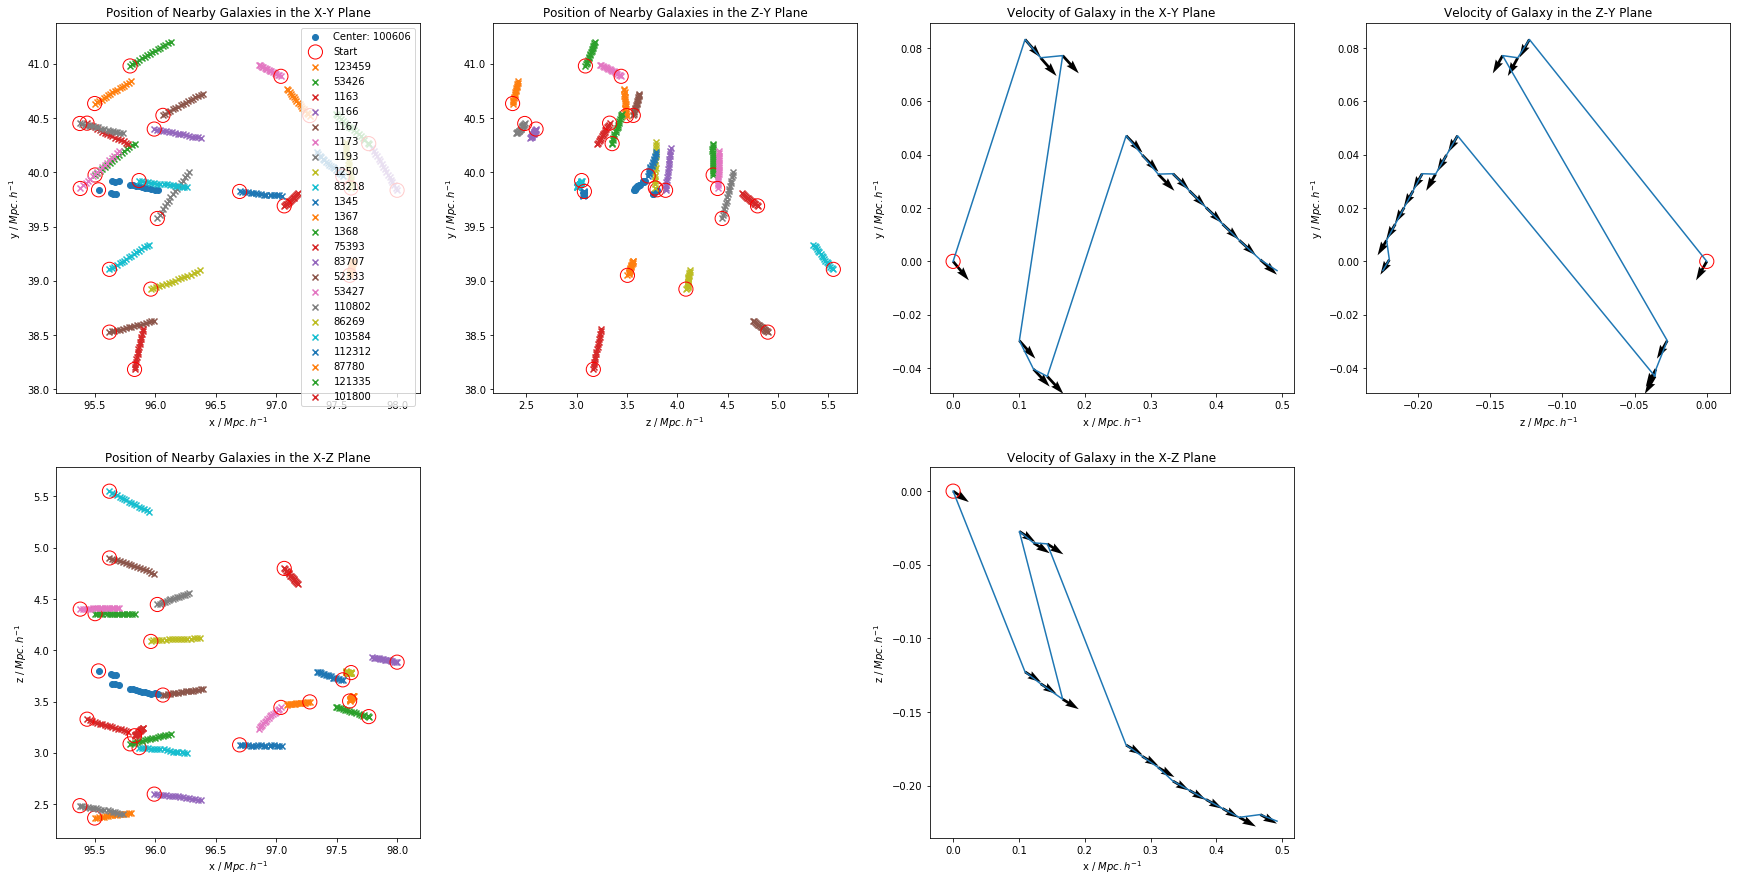

1.11305503904
Nearby galaxies:  [164249, 92769, 176985, 30467, 30468, 120018]


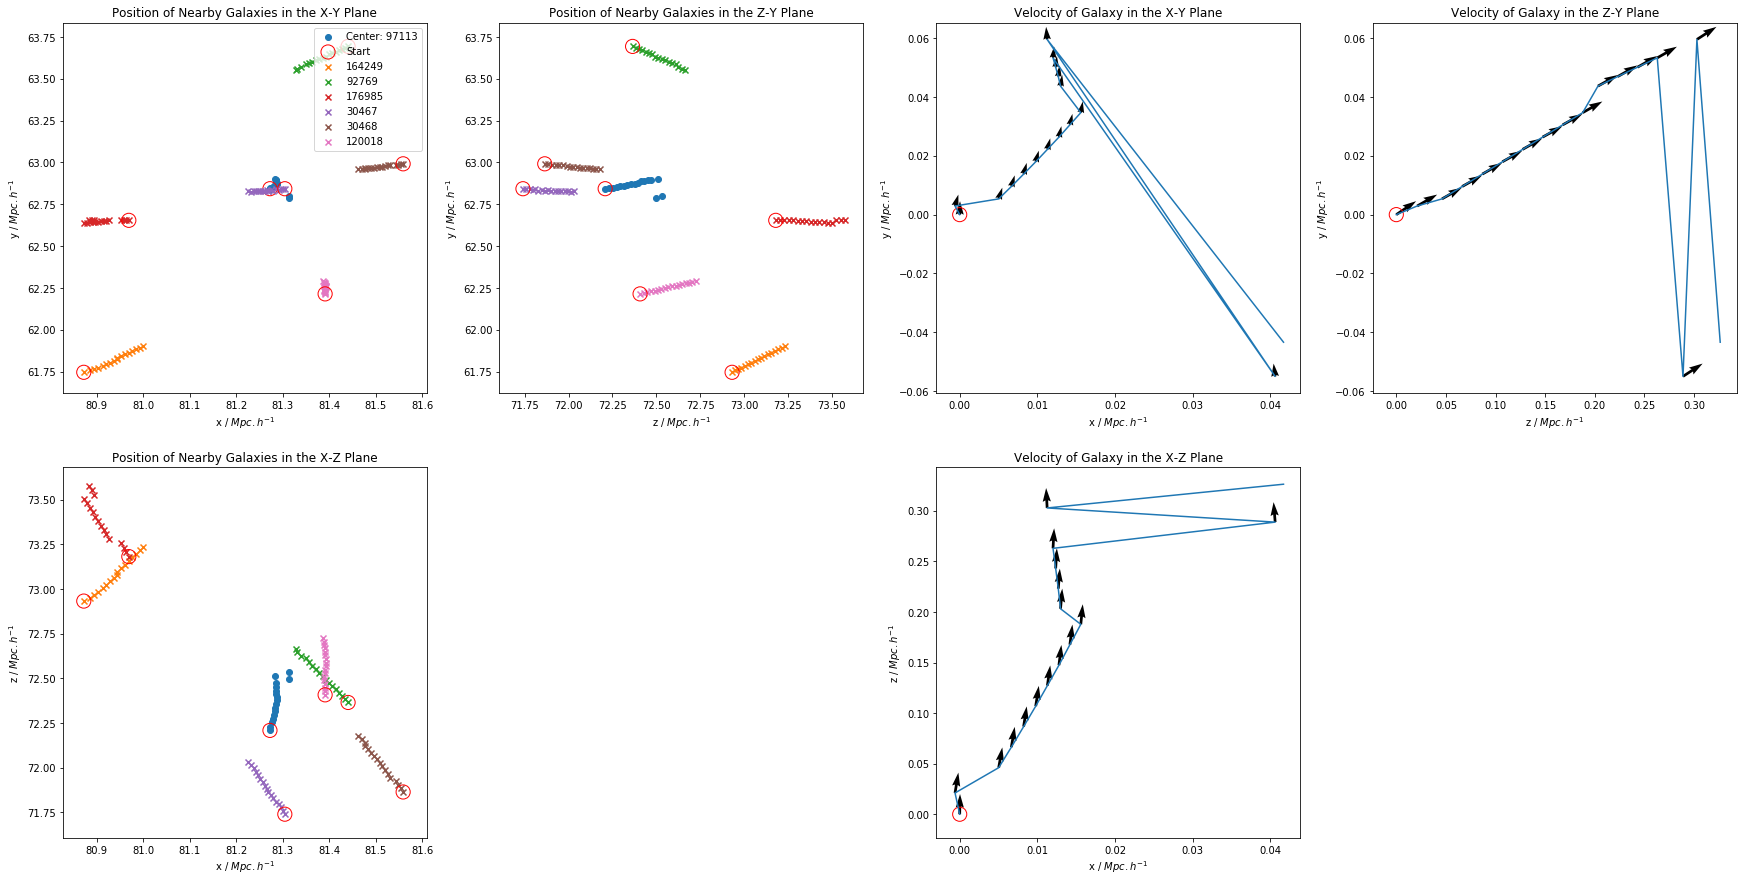

1.54160767504
Nearby galaxies:  [172609, 123776, 99387, 83027, 116210, 173961, 2255, 2259, 2261, 2263, 2266, 2270, 2281, 2285, 2289, 2295, 2298, 2300, 2369, 2377, 199171, 84647, 199417, 192590, 37126, 2336, 119845, 112010, 153041, 55414, 162426, 178981, 121328, 40326]


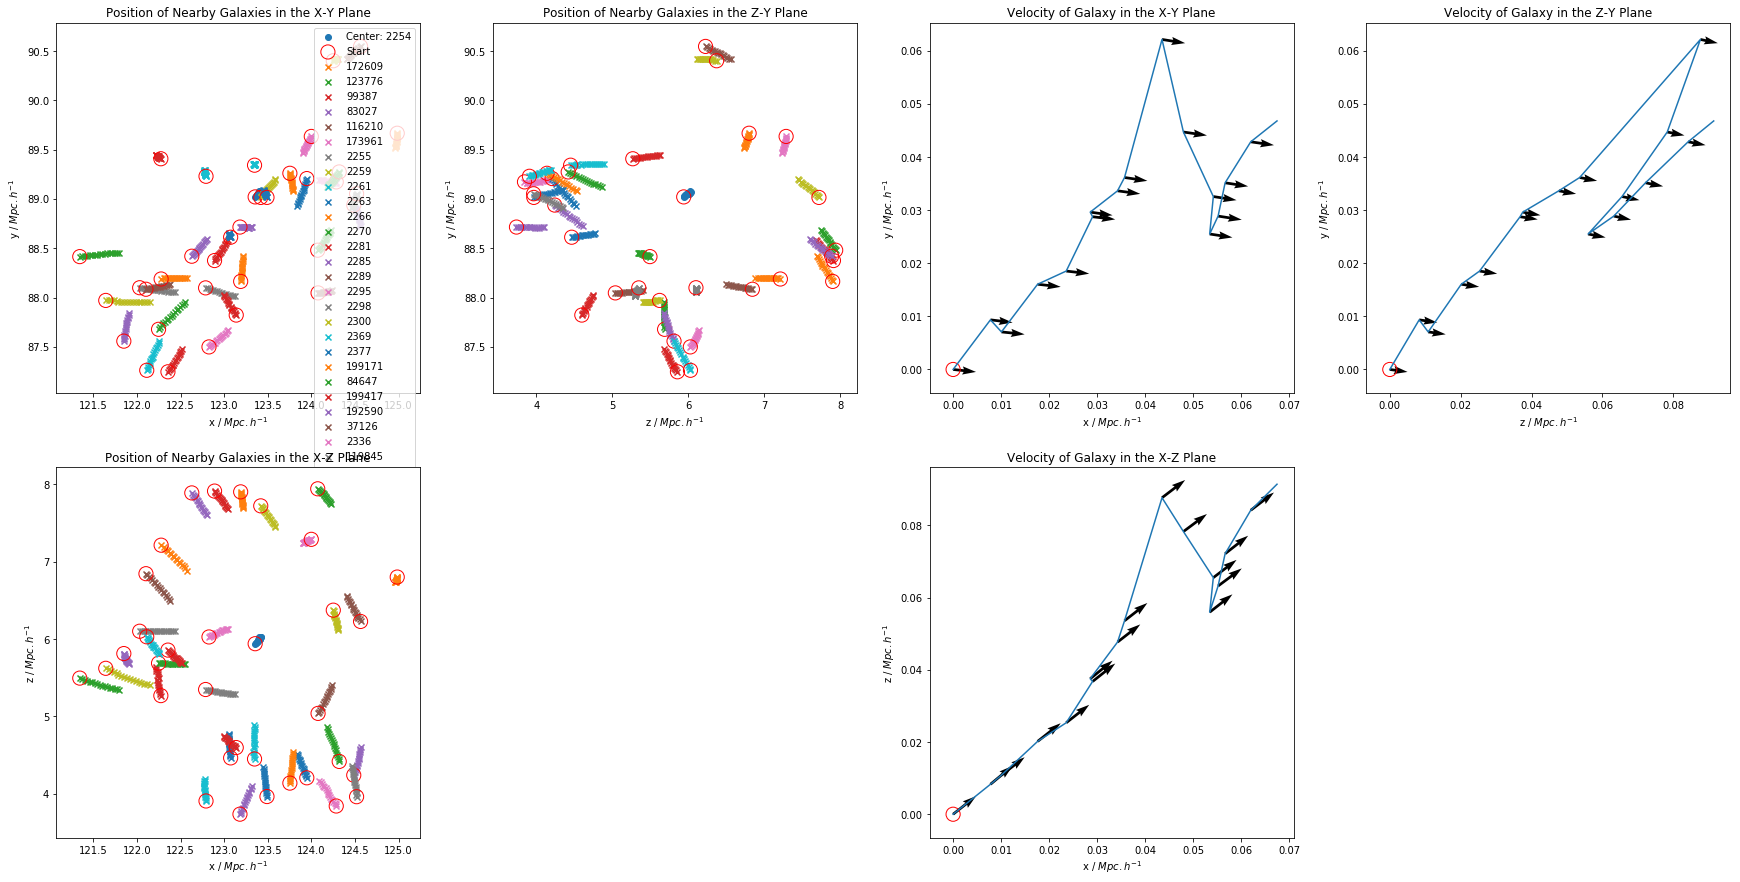

7.37077980205
Nearby galaxies:  [131532, 99192, 107406, 165619, 60395, 164383, 69433, 176251, 37809, 71270]


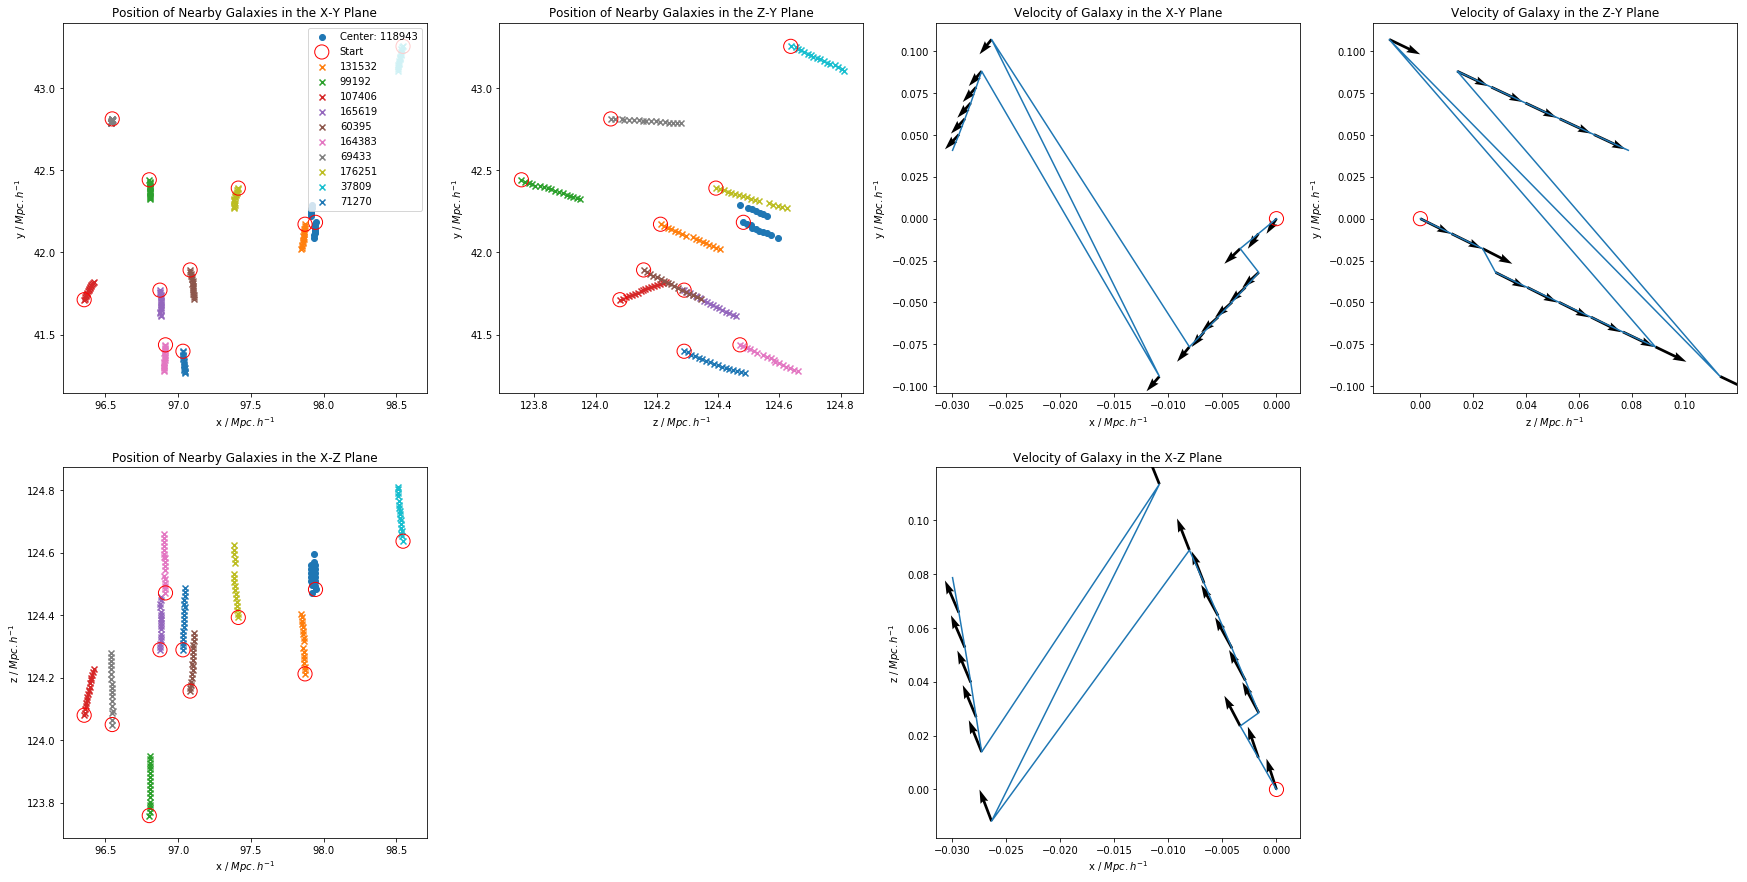

7.8335409659
Nearby galaxies:  [199171, 125659, 110166, 69653, 37126, 2336, 4783, 4784, 4788, 4804, 4808, 4814, 4820, 4821, 4835, 4857, 112010, 7194, 7195, 113719]


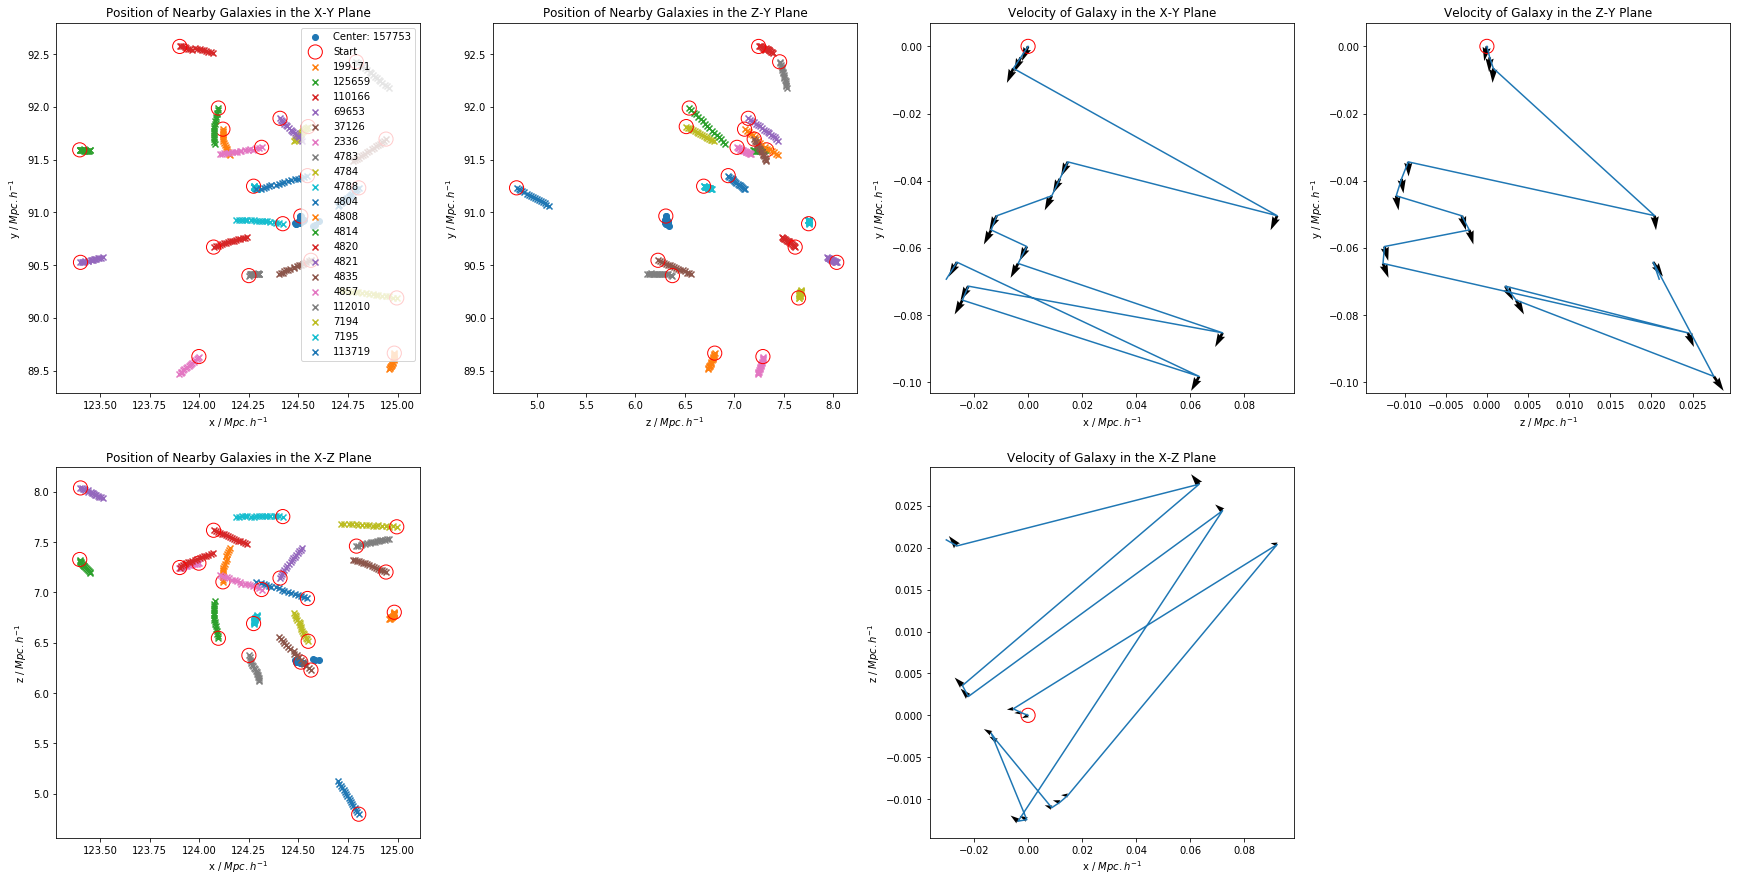

In [512]:
odd_ones =  [400, 2254, 157753, 4786, 43520, 118943, 62135, 31245, 1162, 28539, 97113, 1255, 1, 115283, 100606, 1351, 143165, 127803, 2070, 5687]
odd_ones.sort()
for gal_index in [new_g.keys()[i] for i in [ 371, 1751,  716,   85, 1190,  654, 1669,  630, 1082,  589]]:#odd_ones + [209080]:#[209080]:#odd_ones:
    check_all_points = False
    tree = 977
    # Get a galaxy
    
    gal = new_g[gal_index]
    
    ################################    
    # If you want, you can reporduce the normalised dot-product statistic
    if False:
    
        for i, ss in enumerate(snaps[:-1]):
            dist = np.array(gal[tree][snaps[i+1]][["xgal","ygal","zgal"]].iloc[0]) -  np.array(gal[tree][ss][["xgal","ygal","zgal"]].iloc[0]) #* interp.cosmo.h
            time = interp.cosmo.age(gal[tree][snaps[i+1]]["redshift"]) - interp.cosmo.age(gal[tree][ss]["redshift"])
            av_vel = dist / time.value
            vel = np.array(gal[tree][snaps[i+1]][["vxgal","vygal","vzgal"]].iloc[0])
            prods[i] = np.dot(av_vel/np.linalg.norm(av_vel), vel/np.linalg.norm(vel))
        print np.mean(prods)


    ###########################
    #define box
    dist = 2 # Mpc/h
    
    # Snapshots to get things in the right order
    snaps = snapshot_key_ref[tree]
    snaps.sort()
    
    # get coordinates
    pos = np.asarray([gal[tree][ss][["xgal", "ygal", "zgal"]].values[0] for ss in snaps])
    coords = zip(*pos)
    
    unit_scale = (1 * u.km / u.s).to(u.Mpc / u.Gyr).value 
    
    #get velocities
    vels = np.asarray([gal[tree][ss][["vxgal", "vygal", "vzgal"]].values[0] / interp.cosmo.scale_factor(gal[tree][ss][["redshift"]].values[0])
                            for ss in snaps]) * unit_scale * interp.cosmo.h 

    #get times
    times = np.asarray([interp.cosmo.age(gal[tree][ss][["redshift"]].values[0]) for ss in snaps])
    
    #get distances it would move
    dist_moved = vels[1:] * (times[:-1] - times[1:])
    
    
    #(D_rel)^2 = ( \sum_i=1_to_16 (x_actual_i - x_expected_i)^2 ) / (x_actual_0-x_actual_16)^2
    #x_expected_i = x_actual_(i-1) + v_(i-1) * \delta_t_i
    
    D_rel = np.linalg.norm(pos[:-1] - (pos[1:] + dist_moved), axis=1)/ np.linalg.norm(pos[0]-pos[-1])
    print D_rel.sum()
  

    # Get surrounding galaxys, either simiply around initial point, or the all points.
    # check_all_poins = False makes it much quicker, without losing much
    if check_all_points:
        nearby = [ref for ref, val in new_g.items() if ref!=gal_index and 
                  np.any([np.linalg.norm(val[tree][ss][["xgal", "ygal", "zgal"]].values[0] - np.array(coords)[:,ii])<= dist 
                          for ii, ss in enumerate(snaps)])]
    else:
        nearby = [ref for ref, val in new_g.items() 
                  if ref!=gal_index and np.linalg.norm(val[tree][0][["xgal", "ygal", "zgal"]].values[0] -np.array(coords)[:,0])<= dist]


    near_xs, near_ys, near_zs = [], [], []
    # Get positional data of the nearby galaxies
    for i in nearby:
        gal_tmp = new_g[i]
        tmp_xs, tmp_ys, tmp_zs =zip(*np.asarray([val[["xgal", "ygal", "zgal"]].values[0] for val in gal_tmp[tree].values()]))
        near_xs.append(tmp_xs)
        near_ys.append(tmp_ys)
        near_zs.append(tmp_zs)
    nears = [near_xs, near_ys, near_zs]

    print "Nearby galaxies: ", nearby
    


    # Useful for plotting
    coords_to_use = [(0,1), (2,1), (0,2)]
    lbls = ["x / $Mpc.h^{-1}$", "y / $Mpc.h^{-1}$", "z / $Mpc.h^{-1}$"]
    titles = ["X-Y Plane", "Z-Y Plane", "X-Z Plane"]

    plt.figure(figsize=(30,15))
    # First three plots - positions of the nearby galaxies
    plot_pos = [1, 2,5]
    for sp in range(3):
        plt.subplot(240+plot_pos[sp])
        # Plot the position of the galaxy we're considering
        plt.scatter(coords[coords_to_use[sp][0]], coords[coords_to_use[sp][1]], label=("Center: %d" % gal_index))
        plt.scatter(coords[coords_to_use[sp][0]][-1], coords[coords_to_use[sp][1]][-1], s=200, facecolors='none', edgecolors='red', label="Start")
        # Positions of the naerby galaxies
        for i in range(len(near_xs)):
            plt.scatter(nears[coords_to_use[sp][0]][i], nears[coords_to_use[sp][1]][i], marker="x", label=nearby[i])
            plt.scatter(nears[coords_to_use[sp][0]][i][-1], nears[coords_to_use[sp][1]][i][-1], s=200, facecolors='none', edgecolors='red')#, label="Start")
        # Add labels & titles
        plt.xlabel(lbls[coords_to_use[sp][0]])
        plt.ylabel(lbls[coords_to_use[sp][1]])
        if sp == 0: plt.gca().legend(loc=1)
        plt.title(("Position of Nearby Galaxies in the " + titles[sp]))


    start = [coords[0][-1], coords[1][-1], coords[2][-1]]    
    plot_pos = [3,4,7]
    for plane in range(3):
        plt.subplot(240 + plot_pos[plane]) #, aspect='equal')

        # Plot velocity vectors
        plt.plot(coords[coords_to_use[plane][0]] - start[coords_to_use[plane][0]], coords[coords_to_use[plane][1]] - start[coords_to_use[plane][1]])
        plt.quiver(coords[coords_to_use[plane][0]][1:] - start[coords_to_use[plane][0]], coords[coords_to_use[plane][1]][1:] - start[coords_to_use[plane][1]], dist_moved[:,coords_to_use[plane][0]], dist_moved[:, coords_to_use[plane][1]], angles='xy', scale_units='xy', scale=1)
        #Circle the starting location
        plt.scatter(coords[coords_to_use[plane][0]][-1] - start[coords_to_use[plane][0]], coords[coords_to_use[plane][1]][-1] - start[coords_to_use[plane][1]], s=200, facecolors='none', edgecolors='red', label="Start")

        # Add labels & titles
        plt.title(("Velocity of Galaxy in the " + titles[plane])) 
        plt.xlabel(lbls[coords_to_use[plane][0]])
        plt.ylabel(lbls[coords_to_use[plane][1]])

    plt.show()


In [499]:
data = []
for gal_index in new_g.keys():#[209080]:#odd_ones:
    check_all_points = False

    # Get a galaxy
    #gal_index = 1
    gal = new_g[gal_index]
    tree = 977


    
    # Snapshots to get things in the right order
    snaps = snapshot_key_ref[tree]
    snaps.sort()
    
    # get coordinates
    pos = np.asarray([gal[tree][ss][["xgal", "ygal", "zgal"]].values[0] for ss in snaps])
    coords = zip(*pos)
    
    unit_scale = (1 * u.km / u.s).to(u.Mpc / u.Gyr).value 
    
    #get velocities
    vels = np.asarray([gal[tree][ss][["vxgal", "vygal", "vzgal"]].values[0] / interp.cosmo.scale_factor(gal[tree][ss][["redshift"]].values[0])
                            for ss in snaps]) * unit_scale * interp.cosmo.h 

    #get times
    times = np.asarray([interp.cosmo.age(gal[tree][ss][["redshift"]].values[0]) for ss in snaps])
    
    #get distances it would move
    dist_moved = vels[1:] * (times[:-1] - times[1:])
    
    
    D_rel = np.linalg.norm(pos[:-1] - (pos[1:] + dist_moved), axis=1)/ np.linalg.norm(pos[0]-pos[-1])
    
    data.append(D_rel)

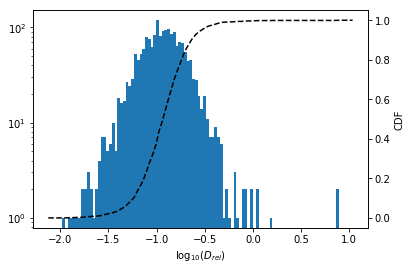

In [505]:
bins = 100
data_to_hist = np.log10(np.array(data).sum(axis=1))

plt.figure()
plt.hist(data_to_hist, log=True, bins = bins)
hist = np.histogram(data_to_hist, bins=bins, normed=False)
hist_dist = scipy.stats.rv_histogram(hist)

xmin, xmax = plt.xlim()
xrang = np.linspace(xmin, xmax, 100)
ax1 = plt.gca()
ax2 = ax1.twinx() 
cdf_line, = ax2.plot(xrang, hist_dist.cdf(xrang), ls='--', c="black", label="CDF")

# Set up axis and range
ax2.set_ylabel('CDF')

ax1.set_xlabel("$\log_{10}(D_{rel})$")
plt.show()

In [511]:
np.argsort(data_to_hist)[-:]

array([ 371, 1751,  716,   85, 1190,  654, 1669,  630, 1082,  589])